### Trabalho e Saude

In [1]:
#Import the basic libraries
import pandas as pd 
import numpy as np 

import unicodedata
import warnings
import string
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor
from math import pi
import math
import geopandas
import geoplot
plt.style.use('ggplot')

## 0. Configuração

In [2]:
# remover 
warnings.filterwarnings("ignore",category=plt.cbook.mplDeprecation)
warnings.filterwarnings("ignore",category=FutureWarning)

# matplotlib
rcParams['axes.titlepad'] = 20 
rcParams['axes.spines.right'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False

# sns
sns.set_style("white")
sns.color_palette("husl", 20)
sns.set_context({"figure.figsize": (18, 5)})


## 1.0 - Carregamento dos datasets

###  1.1 - Doenças 

In [3]:
df_diseases_1 = pd.read_csv('../raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-1/IHME-GBD_2019_DATA-16b07a3d-1.csv')
df_diseases_2 = pd.read_csv('../raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-2/IHME-GBD_2019_DATA-16b07a3d-2.csv')
df_diseases = df_diseases_1.append(df_diseases_2).reset_index()
df_diseases.drop(columns = 'index', inplace = True)

####  1.1.1 - Processamento Doenças

In [4]:
def get_df_dis(_df, year, gender, metric, measure):
    
    year = int(year)
    
    df = _df.copy()
    
    # filter by gender and year (Male or Female)
    df = (_df.copy()[df['sex_name'].isin([gender])
             & (df['year'] == year)
             & (df['metric_name'] == metric)
             & (df['measure_name'] == measure)
            ]
            .drop(columns=['sex_name', 'year', 'metric_name', 'measure_name'])
            .pivot(index='location_name', columns = 'cause_name', values = 'val')
            .drop(columns = ['Stroke','Headache disorders'])
            .rename(columns={'Anxiety disorders':'Anxiety_disorder','Bipolar disorder':'Bipolar_disorder',
                      'Depressive disorders':'Depressive_disorders',
                      'Musculoskeletal disorders': 'Musculoskeletal_disorders'}
            )
         )
    return df

# year = "2011"
# __df = get_df_dis(df_diseases,  year, 'Both','Rate','Incidence')
# __df.head()

### 1.2 - Despesas em saúde ( Publico e Privado )

In [5]:
df_health_cost = pd.read_excel('../raw data/Health_expenditure_WB/Health_expenditure_WB.xls',na_values='..')
df_health_cost.head()


Series Name        Series Code  \
0  Domestic general government health expenditure...  SH.XPD.GHED.PP.CD   
1  Domestic general government health expenditure...  SH.XPD.GHED.PP.CD   
2  Domestic general government health expenditure...  SH.XPD.GHED.PP.CD   
3  Domestic general government health expenditure...  SH.XPD.GHED.PP.CD   
4  Domestic general government health expenditure...  SH.XPD.GHED.PP.CD   

     Country Name Country Code  2000 [YR2000]  2001 [YR2001]  2002 [YR2002]  \
0     Afghanistan          AFG            NaN            NaN       0.693468   
1         Albania          ALB     105.441627     115.829979     117.793068   
2         Algeria          DZA     204.963440     248.090271     252.200760   
3  American Samoa          ASM            NaN            NaN            NaN   
4         Andorra          AND    1267.421753    1324.441040    1485.302856   

   2003 [YR2003]  2004 [YR2004]  2005 [YR2005]  ...  2011 [YR2011]  \
0       5.746409       4.740490       5.127724  ...       7.678760   
1     130.017593     149.126816     152.514328  ...     239.541031   
2     267.399445     258.823029     247.080490  ...     485.345856   
3            NaN            NaN            NaN  ...            NaN   
4    1387.082886    1355.442261    1582.387573  ...    1757.940308   

   2012 [YR2012]  2013 [YR2013]  2014 [YR2014]  2015 [YR2015]  2016 [YR2016]  \
0       6.224039       8.151501       9.018871       9.891986      10.593705   
1     257.224182     271.678131     291.296295     317.450378     331.557312   
2     590.011719     592.809387     675.426331     723.352844     672.498108   
3            NaN            NaN            NaN            NaN            NaN   
4    1801.951050    1843.048828    1970.138794    2135.967285    2118.061523   

   2017 [YR2017]  2018 [YR2018]  2019 [YR2019]  2020 [YR2020]  
0      11.627883       9.641537            NaN            NaN  
1     344.465637     376.501373            NaN            NaN  
2     639.976257     633.798828            NaN            NaN  
3            NaN            NaN            NaN            NaN  
4    2314.099365    2450.407959            NaN            NaN  

[5 rows x 25 columns]

### 1.2.1 - Processamento 

In [6]:
def get_df_hc(_df, year):
    
    df = _df.copy()
    
    # keep only years in columns names
    new_col = list(df.columns)[0:4]
    new_col = new_col + [ str(col.split(' ')[0]) for col in list(df.columns)[4::]]
    
    # reassign years
    df.set_axis(new_col, axis=1, inplace=True)
        
    return (df[['Series Code','Country Name', year]]
            .pivot(index='Country Name', columns = 'Series Code', values = year)
            .rename(columns={'SH.XPD.GHED.PP.CD':'Public_cost','SH.XPD.PVTD.PP.CD':'Private_cost'})
            .rename_axis('location_name')
         )

# __df = get_df_hc(df_health_cost, "2011")
# __df.head()

### 1.3 - PIB per capita

In [7]:
df_gdp = pd.read_excel('../raw data/GPD_WB/GPD_CAPITA_WB.xlsx', na_values='..')
df_gdp.head()

Country Name Country Code                   Series Name     Series Code  \
0     Afghanistan          AFG  GDP per capita (current US$)  NY.GDP.PCAP.CD   
1         Albania          ALB  GDP per capita (current US$)  NY.GDP.PCAP.CD   
2         Algeria          DZA  GDP per capita (current US$)  NY.GDP.PCAP.CD   
3  American Samoa          ASM  GDP per capita (current US$)  NY.GDP.PCAP.CD   
4         Andorra          AND  GDP per capita (current US$)  NY.GDP.PCAP.CD   

   2000 [YR2000]  2001 [YR2001]  2002 [YR2002]  2003 [YR2003]  2004 [YR2004]  \
0            NaN            NaN     179.426611     190.683814     211.382117   
1    1126.683318    1281.659393    1425.124849    1846.118813    2373.579844   
2    1765.022198    1740.607011    1781.825546    2103.381822    2609.952823   
3            NaN            NaN    8700.067705    8856.547459    8578.944723   
4   21854.246803   22971.535536   25066.882211   32271.963902   37969.174991   

   2005 [YR2005]  ...  2011 [YR2011]  2012 [YR2012]  2013 [YR2013]  \
0     242.031285  ...     591.162759     641.871479     637.165523   
1    2673.787283  ...    4437.142885    4247.629984    4413.060861   
2    3113.095331  ...    5462.260897    5591.212353    5498.784095   
3    8444.981700  ...   10294.302265   11568.793001   11505.393714   
4   40066.256919  ...   43335.328862   38686.461264   39538.766722   

   2014 [YR2014]  2015 [YR2015]  2016 [YR2016]  2017 [YR2017]  2018 [YR2018]  \
0     613.856689     578.466353     509.218661     519.884773     493.750418   
1    4578.631994    3952.801215    4124.055726    4531.020806    5284.380184   
2    5494.352336    4187.509727    3945.482081    4111.294110    4153.733978   
3   11507.232349   11843.331183   11696.955562   10823.444804   11466.690706   
4   41303.929371   35762.523074   37474.665406   38962.880354   41793.055258   

   2019 [YR2019]  2020 [YR2020]  
0     507.103432            NaN  
1    5353.244856            NaN  
2    3973.964072            NaN  
3            NaN            NaN  
4   40886.391165            NaN  

[5 rows x 25 columns]

#### 1.3.1 - Processamento PIB

In [8]:
def get_gdp(_df, year):
    
    df = _df.copy()
    
    # keep only years in columns names
    new_col = list(df.columns)[0:4]
    new_col = new_col + [str(col.split(' ')[0]) for col in list(df.columns)[4::]]
    
    # reassign years
    df.set_axis(new_col, axis=1, inplace=True)
        
    return (df[['Series Code','Country Name', year]]
            .pivot(index='Country Name', columns = 'Series Code', values = year)
            .rename(columns={'NY.GDP.PCAP.CD':'GDP_per_cap'})
            .rename_axis('location_name')
         )


# __df = get_gdp(df_gdp, "2011")
# __df.head()


### Import Employment data

In [9]:
df_employment = pd.read_excel('../raw data/Employment_WB_2/Employment_WB_2.xlsx', na_values='..')

### Function to filter usefull employment data

In [10]:
def get_employment(_df, year):
    
    df = _df.copy()
    
    # keep only years in columns names
    new_col = list(df.columns)[0:4]
    new_col = new_col + [str(col.split(' ')[0]) for col in list(df.columns)[4::]]
    
    # reassign years
    df.set_axis(new_col, axis=1, inplace=True)
        
    return (df[['Series Code','Country Name', year]]
            .pivot(index='Country Name', columns = 'Series Code', values = year)
            .rename(columns={'SL.AGR.EMPL.FE.ZS':'per_female_agriculture',
                      'SL.AGR.EMPL.MA.ZS':'per_male_agriculture',
                      'SL.AGR.EMPL.ZS':'per_total_agriculture',
                      'SL.EMP.TOTL.SP.ZS':'per_total_employment',
                      'SL.EMP.TOTL.SP.MA.ZS':'per_male_employment',
                      'SL.EMP.TOTL.SP.FE.ZS':'per_female_employment',
                      'SL.IND.EMPL.FE.ZS':'per_female_industry',
                      'SL.IND.EMPL.MA.ZS':'per_male_industry',
                      'SL.IND.EMPL.ZS':'per_total_industry',
                      'SL.SRV.EMPL.FE.ZS':'per_female_services',
                      'SL.SRV.EMPL.MA.ZS':'per_male_services',
                      'SL.SRV.EMPL.ZS':'per_total_services'})
            .rename_axis('location_name')
         )

# __df = get_employment(df_employment, "2011")
# __df.head()

### Unemployment & Labor force data

In [11]:
df_unemp_lforce = pd.read_excel('../raw data/UNEMP_LABORFORCE/unemp_lforce.xlsx',na_values='..')

In [12]:
def get_unemp_lforce(_df, year):
    df = _df.copy()
    
    # keep only years in columns names
    new_col = list(df.columns)[0:4]
    new_col = new_col + [str(col.split(' ')[0]) for col in list(df.columns)[4::]]
    
    # reassign years
    df.set_axis(new_col, axis=1, inplace=True)
        
    return (df[['Series Code','Country Name', year]]
            .pivot(index='Country Name', columns = 'Series Code', values = year)
            .rename(columns={'SL.TLF.CACT.ZS':'Total_Labor_Force', 'SL.UEM.TOTL.ZS':'Unemployment_rate'})
            .rename_axis('location_name')
         )

# __df = get_unemp_lforce(df_unemp_lforce, "2011")
# __df.head()

### Hours worked

In [13]:
df_hours_work = pd.read_excel('../raw data/HOURS_ILO/HOURS_ILO.xlsx',na_values='..')

In [14]:
def get_hours_work(df, year):
    
    year = int(year)
    
    # remove unnecessary years
    df = df[['ref_area.label','obs_value']].loc[df.time == year].copy()
    
    df.set_index('ref_area.label', inplace = True)
    df = df.rename_axis('location_name') 
    df.rename(columns={'obs_value':'Weekly_work_hours'}, inplace = True)
    df['Weekly_work_hours'] =  df['Weekly_work_hours'] * 1000
    
    return df

### Population size

In [15]:
df_pop = pd.read_excel('../raw data/Population/Population.xlsx',na_values='..')

In [16]:
def get_pop(_df, year):
    
    df = _df.copy()
    
    # keep only years in columns names
    new_col = list(df.columns)[0:4]
    new_col = new_col + [str(col.split(' ')[0]) for col in list(df.columns)[4::]]
    
    # reassign years
    df.set_axis(new_col, axis=1, inplace=True)
        
    df =  (df[['Series Code','Country Name', year]]
            .pivot(index='Country Name', columns = 'Series Code', values = year)
            .rename(columns={'SP.POP.0014.TO':'Pop_Under15','SP.POP.TOTL':'Pop_Total'})
            .rename_axis('location_name')
         )
    
    return (df.assign(Pop_Over15 = df['Pop_Total'] - df['Pop_Under15'])
              .drop(columns =['Pop_Total','Pop_Under15'])
           )

# __df = get_pop(df_pop, "2011")
# __df.head()

### SUMMARY OF ALL DATA GATHERED

### Merging all, considering all genders & yr = 2011

In [17]:
def remove_accent_chars_join(s):
    return u"".join([c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c)])

def clean_column_names(column): 
    return remove_accent_chars_join(
        column.lower()
        .replace(" ", "_")
        .replace("/", "")
        .replace(".", "")
        .replace(",", "")
    )

def transform(_df,  year):
    
    df = _df.copy()

    df = (df
          .assign(mental_disorders = df['anxiety_disorder']+df['bipolar_disorder']+df['depressive_disorders'])
          .assign(total_health_cost = df['private_cost']+df['public_cost'])
          .assign(unemp_pc = (df['unemployment_rate']*df['total_labor_force'])/10000)
          .assign(week_hours_pc = df['weekly_work_hours']/(df['pop_over15']*(df['per_total_employment'])/100))
          .assign(year = int(year))
         )
    
    return (df
            # group all diseases in single total diseases var
            .assign(all_disorders = df['mental_disorders']+df['musculoskeletal_disorders']+df['dermatitis'])
           )


def get_by_year(year, country_list = [], drop_col=True):
    
    # -------------------------------
    # Load
    df1 = get_df_dis(df_diseases, year, 'Both','Rate','Incidence')
    df2 = get_df_hc(df_health_cost, year)
    df3 = get_gdp(df_gdp, year)
    df4 = get_employment(df_employment, year)
    df5 = get_unemp_lforce(df_unemp_lforce, year)
    df6 = get_hours_work(df_hours_work, year)
    df7 = get_pop(df_pop,year)
    
    # -------------------------------
    # merge by index = localname
    df = (df1
          .merge(df2, right_index=True, left_index=True, how='inner')
          .merge(df3, right_index=True, left_index=True, how='inner')
          .merge(df4, right_index=True, left_index=True, how='inner')
          .merge(df5, right_index=True, left_index=True, how='inner')
          .merge(df6, right_index=True, left_index=True, how='inner')
          .merge(df7, right_index=True, left_index=True, how='inner')
         )
    
    # -------------------------------
    # Filter by country
    if len(country_list):
        df = df[df.index.isin(country_list)]
    
    # -------------------------------
    # Transform and Clean
    
    # clean columns names
    df.columns = df.columns.map(clean_column_names)
    
    columns_to_keep = ['year', 'dermatitis', 'musculoskeletal_disorders', 'gdp_per_cap',
       'per_total_employment', 'week_hours_pc', 'mental_disorders',
       'total_health_cost', 'all_disorders', 'weekly_work_hours', 'unemp_pc']
   
    if drop_col:
        
             df = (df
            .pipe(transform, year)
            [columns_to_keep]
           )
    else:
    
        df = (df
                .pipe(transform, year)
               )
    
    return df

### 3. Selecionar os países e ano para o estudo

Os 28 países membros da união européia

In [18]:
eu_countries_list = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 
                     'Denmark', 'Estonia','Finland', 'France', 'Germany', 
                     'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 
                     'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 
                     'Portugal', 'Romania', 'Spain', 'Sweden', 'Slovakia', 
                     'Slovenia', 'United Kingdom', 'Czechia' ]

df_2011 = get_by_year('2011', country_list= eu_countries_list)
df_2017 = get_by_year('2017', country_list= eu_countries_list)

# df_2011.head(28)
# df_2017.head(28)

### Visão geral 

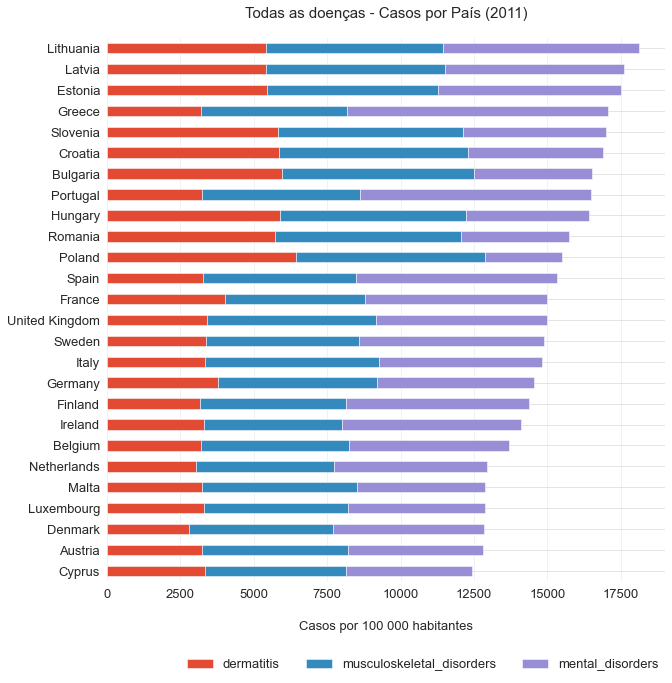

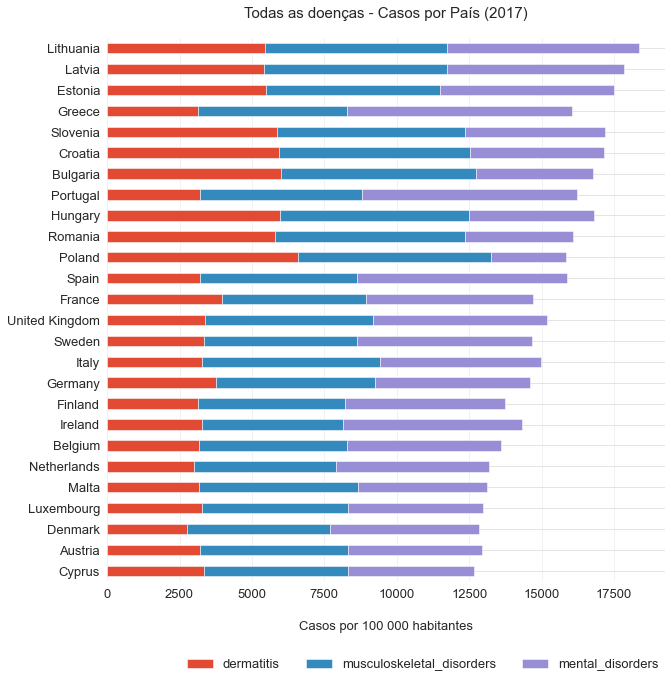

In [19]:
# generate random name to save fig
def random_str():
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(10))
    
def barplot_deseases_by_countries(df, t='', l=''):
    
    ax = (df[['dermatitis', 'musculoskeletal_disorders','mental_disorders' ]]
            .plot.barh(stacked=True)
         )
    
    ax.figure.set_size_inches(10, 10)

    plt.title(t, fontsize=15)

    plt.ylabel('')
    plt.xlabel(l, fontsize=13, labelpad= 20)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    ax.yaxis.grid(color='#dedede')
    ax.xaxis.grid(color='#eeeeee')

    plt.legend(ncol=3, bbox_to_anchor=(1.01, -0.12), frameon=False, fontsize=13)
    sns.despine(top=True, right=True, left=True, bottom=True)

    # ax.figure.savefig(f'../figures/{random_str()}.png', dpi=ax.figure.dpi, bbox_inches='tight', pad_inches=0.1)

    plt.show()


df_2011_sorted = df_2011.sort_values('all_disorders')
barplot_deseases_by_countries(df_2011_sorted,
                         t ='Todas as doenças - Casos por País (2011)', 
                         l = 'Casos por 100 000 habitantes'
                        )


df_2017_sorted = df_2017.reindex(df_2011_sorted.index)
barplot_deseases_by_countries(df_2017_sorted, 
                         t ='Todas as doenças - Casos por País (2017)', 
                         l = 'Casos por 100 000 habitantes'
                        )


### Gerar um dataset com a variação entre 2017 e 2011

In [20]:
df_variation = df_2017 - df_2011
df_variation.head()

year  dermatitis  musculoskeletal_disorders  gdp_per_cap  \
location_name                                                             
Austria           6  -31.354727                 127.928526 -3948.446447   
Belgium           6  -32.267506                  80.867757 -3155.901993   
Bulgaria          6   52.875268                 155.710800   524.656665   
Croatia           6   84.826955                 136.253846 -1157.899405   
Cyprus            6  -16.055713                 184.662914 -6057.691399   

               per_total_employment  week_hours_pc  mental_disorders  \
location_name                                                          
Austria                   -0.090000      -1.792272         28.955898   
Belgium                    0.320000      -0.322518       -162.317024   
Bulgaria                   5.420002      -0.276033         13.850054   
Croatia                    1.100002      -0.377954         60.878458   
Cyprus                    -2.829998      -0.591481         54.612191   

               total_health_cost  all_disorders  weekly_work_hours  unemp_pc  
location_name                                                                 
Austria              1208.413574     125.529697           -25705.0  0.005917  
Belgium              1020.051147    -113.716773          4487991.0 -0.000046  
Bulgaria              459.757385     222.436122          6922717.0 -0.024985  
Croatia               160.699951     281.959258          -693187.0 -0.013021  
Cyprus                332.166504     223.219392          -169801.0  0.019163

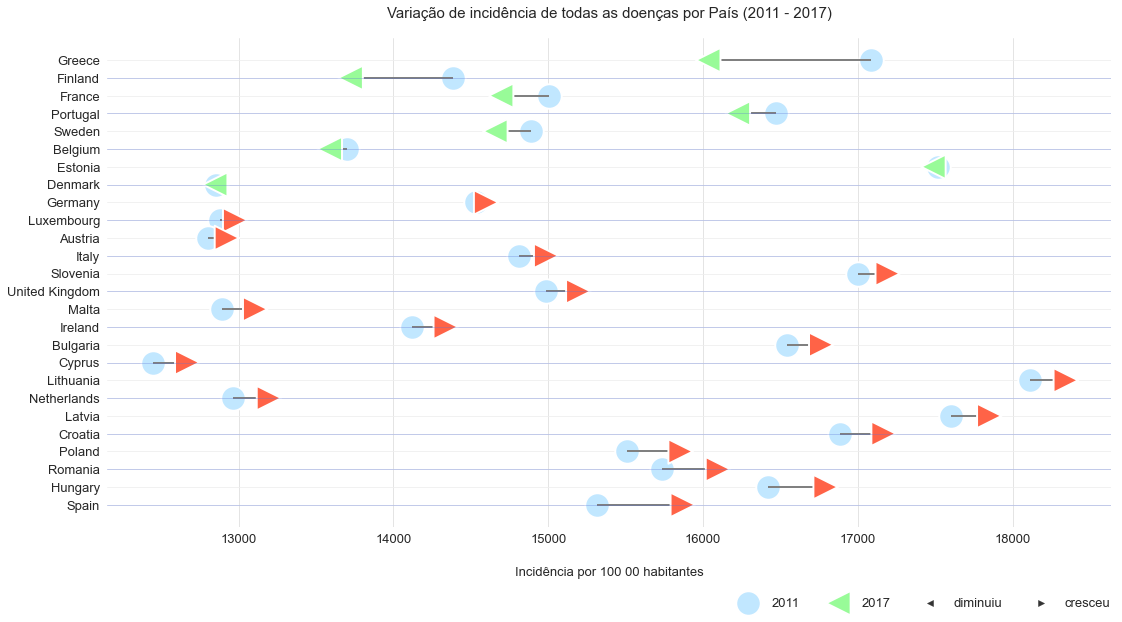

In [21]:
# Plot Variation of Deseases by Euro Country
def plot_variation_by_countries(df1, df2, desease = '', title='', xlabel=''):
    fig, axes = plt.subplots(1, 1, sharex=False, figsize=(18, 9))

    sns.scatterplot(axes=axes, data=df1.reset_index(), 
                    y='location_name', marker="o", 
                    color="#c1e7ff", x=desease, s=600,
                    label=f'2011'
                   )
    
    plt.hlines(df1.index, df1[desease], df2[desease], lw=2, color='gray', zorder=1)
    
    sns.scatterplot(axes=axes, data=df2.reset_index(), y='location_name', 
                        markers={'cresceu':'>', 'diminuiu':'<'}, 
                        c=df2['color'], x=desease, s=600,  style='shape',
                        label=f'2017'
                   )
     
    # draw line each even to add some visual separation 
    counter = 0
    for country in df1.index.values:
        if counter % 2:
            axes.axhline(df1.index[counter], ls='-', lw=1, color='#5872d7', alpha=0.3,  zorder=1)
        counter += 1
        
    plt.title(title, fontsize=15)
    
    plt.ylabel('')
    plt.xlabel(xlabel, fontsize=13, labelpad=20)
    
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    axes.yaxis.grid(color='#eeeeee') # horizontal linessx
    axes.xaxis.grid(color='#dedede') # horizontal linessx
    
    plt.legend(ncol=4, bbox_to_anchor=(1.01, -0.12), frameon=False, fontsize=13)
    sns.despine(top=True, right=True, left=True, bottom=True)
    plt.show()
    
    # fig.savefig(f'../figures/{random_str()}.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.1)


df_to_sort = df_variation.sort_values('all_disorders', ascending = True)
df_2011_sorted = df_2011.reindex(df_to_sort.index, copy=True)
df_2011_sorted['all_disorders_variatio'] =  df_variation["all_disorders"]

df_2017_sorted = df_2017.reindex(df_to_sort.index, copy=True)
df_2017_sorted['all_disorders_variatio'] =  df_variation["all_disorders"]
df_2017_sorted['shape'] = df_2017_sorted['all_disorders_variatio'].apply(lambda x: "cresceu" if x > 0 else "diminuiu")
df_2017_sorted['color'] = df_2017_sorted['all_disorders_variatio'].apply(lambda x: "tomato" if x > 0 else "palegreen")


plot_variation_by_countries(df_2011_sorted, df_2017_sorted, desease='all_disorders', 
                            title='Variação de incidência de todas as doenças por País (2011 - 2017)',
                            xlabel = 'Incidência por 100 00 habitantes')


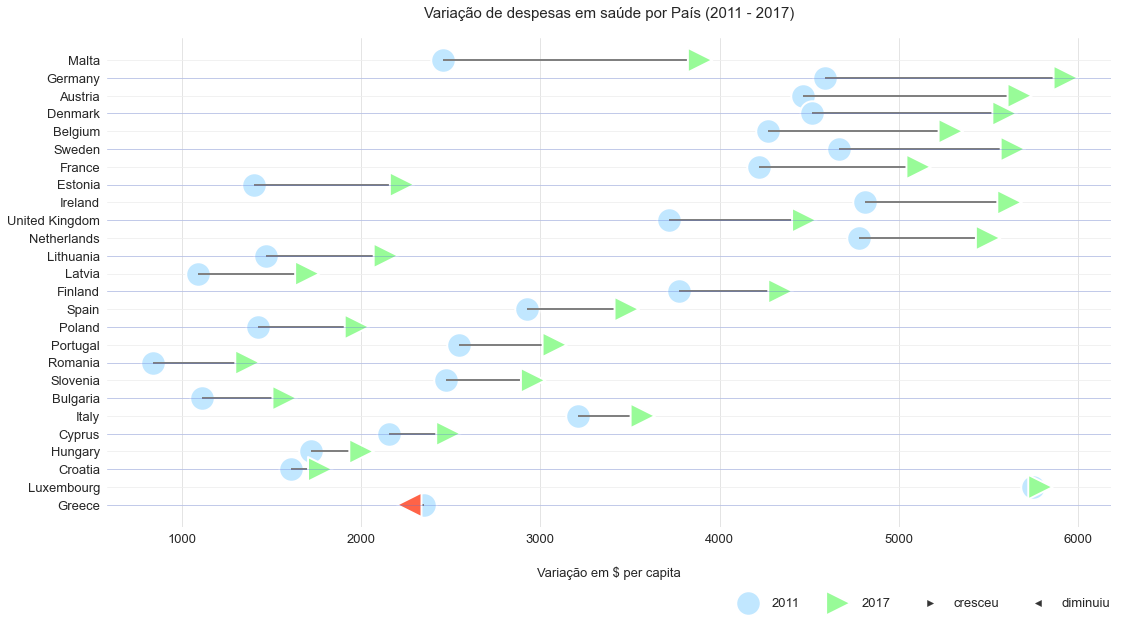

In [22]:
df_to_sort = df_variation.sort_values('total_health_cost', ascending = False)

df_2011_sorted = df_2011.reindex(df_to_sort.index, copy=True)

df_2017_sorted = df_2017.reindex(df_to_sort.index, copy=True)
df_2017_sorted['total_health_cost_variation'] =  df_variation["total_health_cost"]
df_2017_sorted['shape'] = df_2017_sorted['total_health_cost_variation'].apply(lambda x: "diminuiu" if x < 0 else "cresceu" )
df_2017_sorted['color'] = df_2017_sorted['total_health_cost_variation'].apply(lambda x: "tomato" if x < 0 else "palegreen")

plot_variation_by_countries(df_2011_sorted, df_2017_sorted, desease='total_health_cost', 
                            title='Variação de despesas em saúde por País (2011 - 2017)',
                            xlabel='Variação em $ per capita'
                           )



    

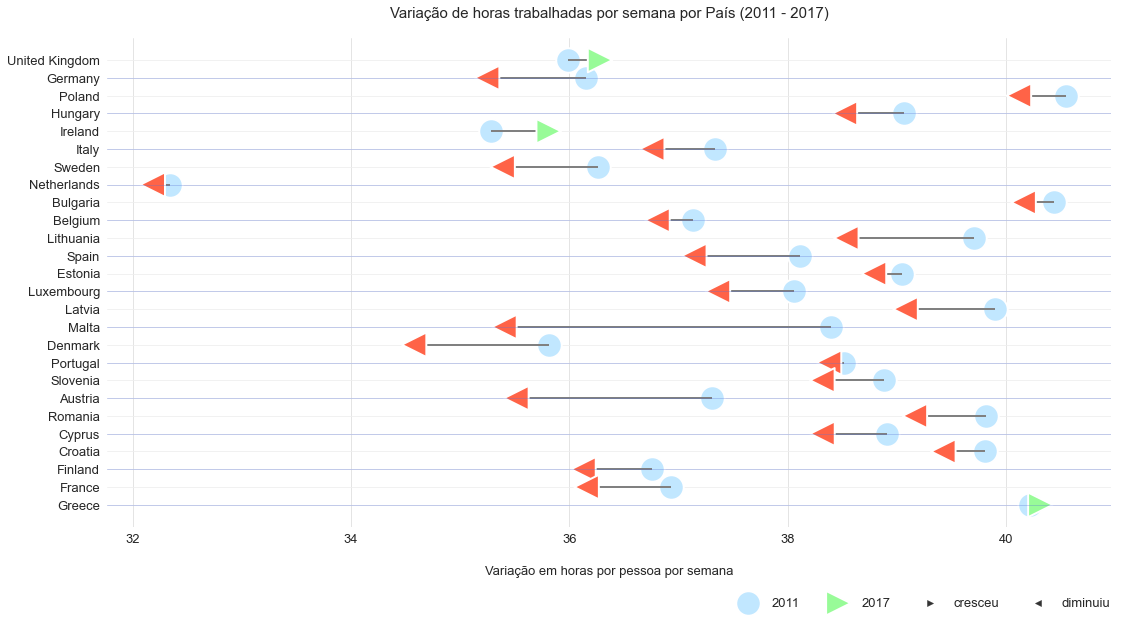

In [23]:
df_to_sort = df_variation.sort_values('weekly_work_hours', ascending = False)

df_2011_sorted = df_2011.reindex(df_to_sort.index, copy=True)
df_2017_sorted = df_2017.reindex(df_to_sort.index, copy=True)
df_2017_sorted['weekly_work_hours_variation'] =  df_variation["week_hours_pc"]
df_2017_sorted['shape'] = df_2017_sorted['weekly_work_hours_variation'].apply(lambda x: "diminuiu" if x < 0 else "cresceu" )
df_2017_sorted['color'] = df_2017_sorted['weekly_work_hours_variation'].apply(lambda x: "tomato" if x < 0 else "palegreen")


plot_variation_by_countries(df_2011_sorted, df_2017_sorted, desease='week_hours_pc', 
                            title='Variação de horas trabalhadas por semana por País (2011 - 2017)',
                            xlabel='Variação em horas por pessoa por semana'
                           )

### PLOT

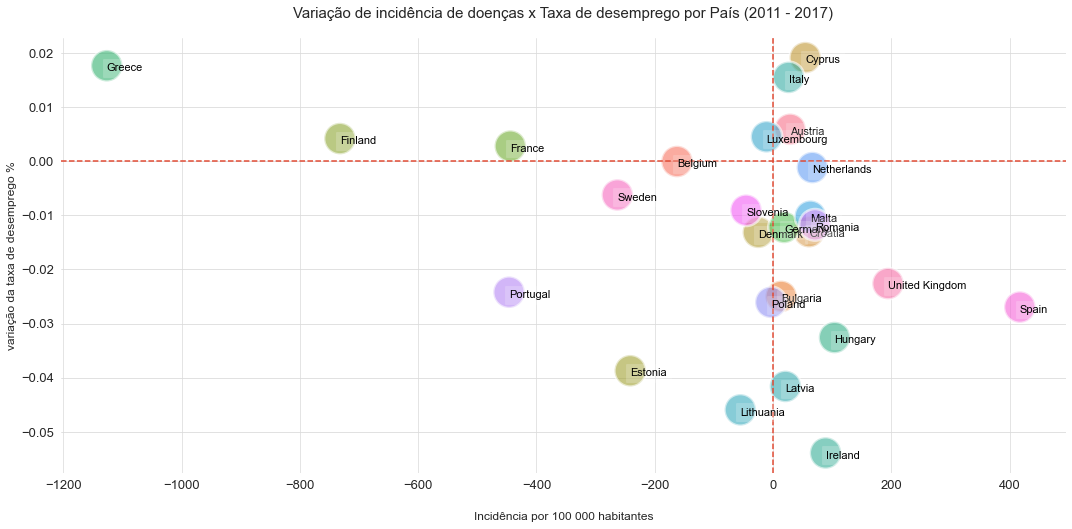

In [24]:
def plot_desease_correlation(_df, x='', y='', title='', xlim=None, ylim=None, xlabel='', ylabel=''):

    df = _df.copy().reset_index()

    fig, axes = plt.subplots(1, 1, sharex=False, figsize=(18, 8))
    sns.scatterplot(ax=axes, data=df, x=x, y=y, s=1000, alpha = 0.6, hue='location_name')
    
    # Add country name
    for i in range(df.shape[0]):
        plt.text(x=df[x][i], y=df[y][i] - 0.001,  s= df['location_name'][i], 
              fontdict=dict(color="black", size=11),
              bbox=dict(facecolor="white",alpha=0.2))
     
    #axes.get_legend().remove()
    axes.xaxis.grid(color='#dedede')
    axes.yaxis.grid(color='#dadada')
    
    if xlim:
        axes.set_xlim(xlim)
        
    if ylim:
        axes.set_ylim(ylim)
    
    axes.axhline(0, ls='--')
    axes.axvline(0, ls='--')
    
    plt.xlabel(xlabel, fontsize=12, labelpad=20)
    plt.ylabel(ylabel, fontsize=12)
    
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    plt.title(title, fontsize=15)

    #axes.get_legend().set_bbox_to_anchor((1, 1))
    axes.get_legend().remove()

    sns.despine(top=True, right=True, left=True, bottom=True)
    plt.show()
    
    # fig.savefig(f'../figures/{random_str()}.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.1)
    

plot_desease_correlation(df_variation, x='mental_disorders', 
                         y='unemp_pc', 
                         title='Variação de incidência de doenças x Taxa de desemprego por País (2011 - 2017)',
                         xlabel = 'Incidência por 100 000 habitantes',
                         ylabel = 'variação da taxa de desemprego %'
                         #xlim=(-1200, 1200), ylim=(-0.06, 0.06)
                        )


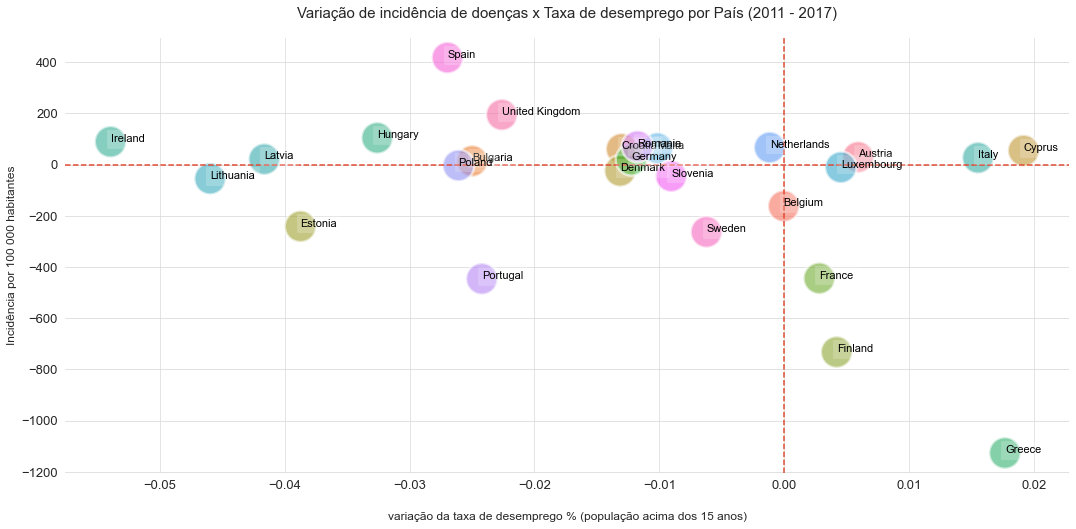

In [25]:
plot_desease_correlation(df_variation, x='unemp_pc', 
                         y='mental_disorders', 
                         title='Variação de incidência de doenças x Taxa de desemprego por País (2011 - 2017)',
                         xlabel = 'variação da taxa de desemprego % (população acima dos 15 anos)',
                         ylabel = 'Incidência por 100 000 habitantes'
                         #xlim=(-1200, 1200), ylim=(-0.06, 0.06)
                        )


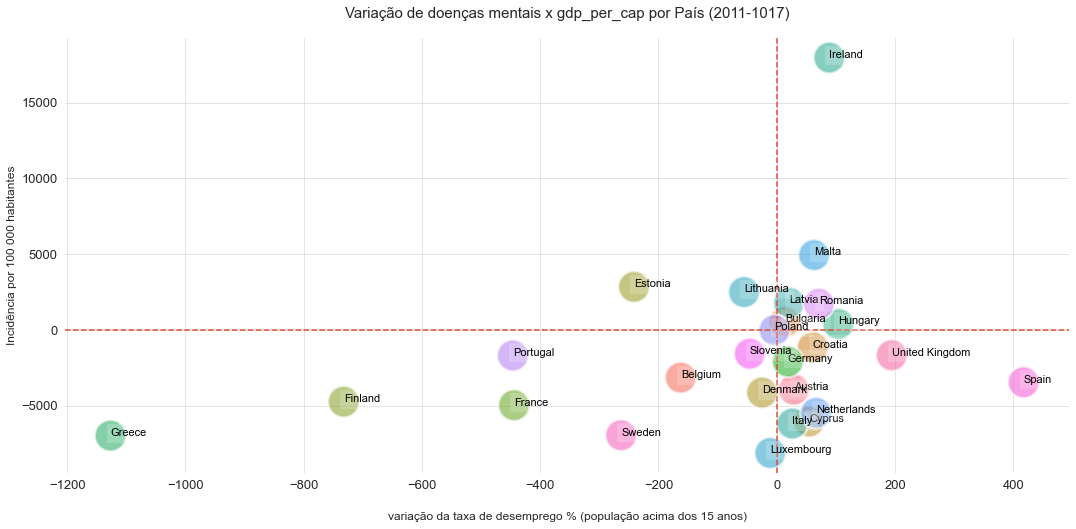

In [26]:
plot_desease_correlation(df_variation, x='mental_disorders', 
                         y='gdp_per_cap', 
                         title='Variação de doenças mentais x gdp_per_cap por País (2011-1017)',
                         xlabel = 'variação da taxa de desemprego % (população acima dos 15 anos)',
                         ylabel = 'Incidência por 100 000 habitantes'
                         #xlim=(-1200, 1200),
                         #ylim=(-45000, 45000)
                        )

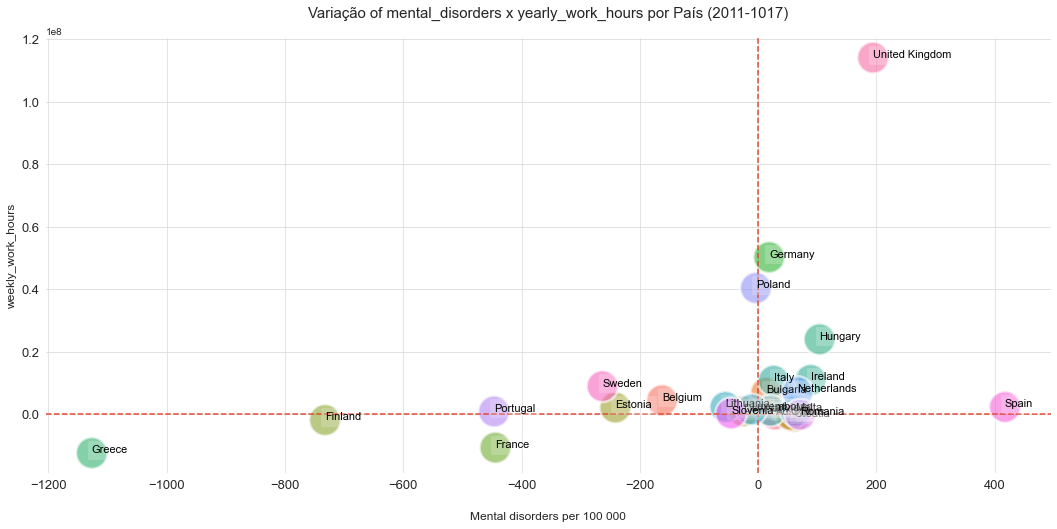

In [27]:
plot_desease_correlation(df_variation, x='mental_disorders', 
                         y='weekly_work_hours', 
                         title='Variação of mental_disorders x yearly_work_hours por País (2011-1017)',
                         xlabel = 'Mental disorders per 100 000',
                         ylabel = 'weekly_work_hours'
                        )

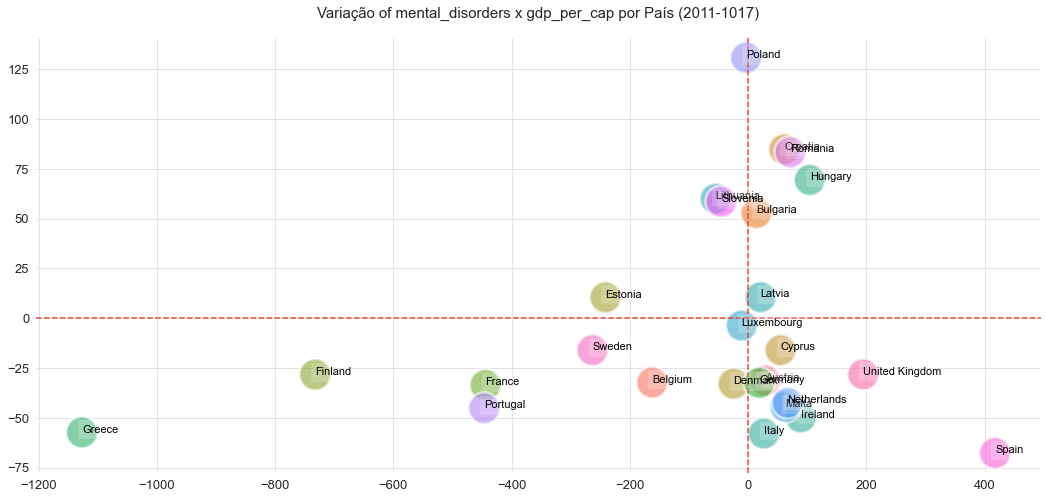

In [28]:
plot_desease_correlation(df_variation, x='mental_disorders', 
                         y='dermatitis', 
                         title='Variação of mental_disorders x gdp_per_cap por País (2011-1017)',
                         #xlim=(-1200, 1200),
                         #ylim=(-15000, 45000)
                        )

In [29]:
df_variation.columns

Index(['year', 'dermatitis', 'musculoskeletal_disorders', 'gdp_per_cap',
       'per_total_employment', 'week_hours_pc', 'mental_disorders',
       'total_health_cost', 'all_disorders', 'weekly_work_hours', 'unemp_pc'],
      dtype='object')

### MAP

In [30]:
#!pip install pycountry
#!pip install geopandas
#!pip install geopy

In [31]:
import pycountry 
import geopandas
from geopandas import GeoDataFrame
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

In [32]:
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE


df = df_variation.copy()
df['CODE'] = alpha3code(df.index)
df.head()

year  dermatitis  musculoskeletal_disorders  gdp_per_cap  \
location_name                                                             
Austria           6  -31.354727                 127.928526 -3948.446447   
Belgium           6  -32.267506                  80.867757 -3155.901993   
Bulgaria          6   52.875268                 155.710800   524.656665   
Croatia           6   84.826955                 136.253846 -1157.899405   
Cyprus            6  -16.055713                 184.662914 -6057.691399   

               per_total_employment  week_hours_pc  mental_disorders  \
location_name                                                          
Austria                   -0.090000      -1.792272         28.955898   
Belgium                    0.320000      -0.322518       -162.317024   
Bulgaria                   5.420002      -0.276033         13.850054   
Croatia                    1.100002      -0.377954         60.878458   
Cyprus                    -2.829998      -0.591481         54.612191   

               total_health_cost  all_disorders  weekly_work_hours  unemp_pc  \
location_name                                                                  
Austria              1208.413574     125.529697           -25705.0  0.005917   
Belgium              1020.051147    -113.716773          4487991.0 -0.000046   
Bulgaria              459.757385     222.436122          6922717.0 -0.024985   
Croatia               160.699951     281.959258          -693187.0 -0.013021   
Cyprus                332.166504     223.219392          -169801.0  0.019163   

              CODE  
location_name       
Austria        AUT  
Belgium        BEL  
Bulgaria       BGR  
Croatia        HRV  
Cyprus         CYP

In [33]:
longitude = []
latitude = []
   
# find the country coordinate
def findGeocode(city):
       
    try:
        geolocator = Nominatim(user_agent="your_app_name")
        return geolocator.geocode(city)
      
    except GeocoderTimedOut:
          
        return findGeocode(city)    


# findGeocode for each country
for i in (df.index):
    if findGeocode(i) != None:
        loc = findGeocode(i)

        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

df["Longitude"] = longitude
df["Latitude"] = latitude

In [34]:
# load geopandas naturalearth_lowres
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns=['pop_est', 'continent', 'location_name', 'CODE_2', 'gdp_md_est', 'geometry']

In [35]:
world.head()


world.set_index('location_name')

pop_est      continent CODE_2  gdp_md_est  \
location_name                                                           
Fiji                         920938        Oceania    FJI      8374.0   
Tanzania                   53950935         Africa    TZA    150600.0   
W. Sahara                    603253         Africa    ESH       906.5   
Canada                     35623680  North America    CAN   1674000.0   
United States of America  326625791  North America    USA  18560000.0   
...                             ...            ...    ...         ...   
Serbia                      7111024         Europe    SRB    101800.0   
Montenegro                   642550         Europe    MNE     10610.0   
Kosovo                      1895250         Europe    -99     18490.0   
Trinidad and Tobago         1218208  North America    TTO     43570.0   
S. Sudan                   13026129         Africa    SSD     20880.0   

                                                                   geometry  
location_name                                                                
Fiji                      MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
Tanzania                  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
W. Sahara                 POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
Canada                    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
United States of America  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
...                                                                     ...  
Serbia                    POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
Montenegro                POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
Kosovo                    POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
Trinidad and Tobago       POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
S. Sudan                  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 5 columns]

##### Agregar df e world

In [37]:
df_merged = df.copy().merge(world.set_index('location_name'), left_index=True, right_index=True)
df_merged_df = GeoDataFrame(df_merged)


#### Plot mapa

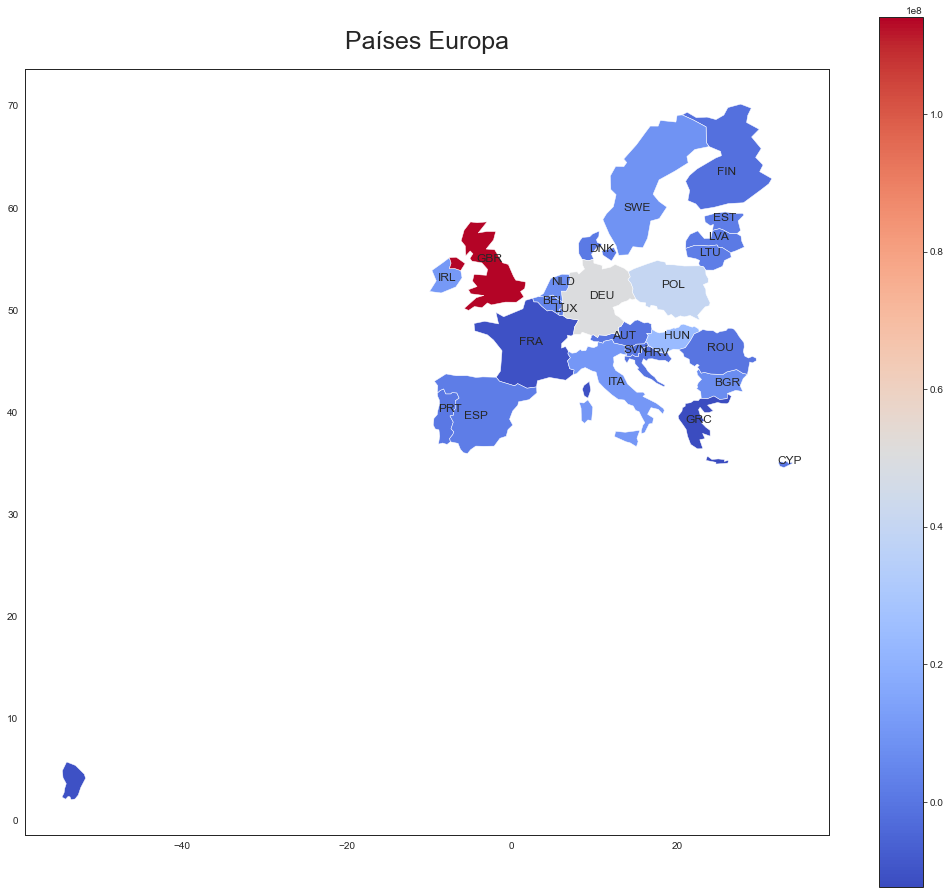

In [38]:
df_merged_df.plot(column='weekly_work_hours', 
           figsize=(18, 16),
           legend=True,cmap='coolwarm')

plt.title('Países Europa', fontsize=25)

# add countries names and numbers 
for i in range(0, len(list(df.index)) - 1):
    plt.text(float(df_merged_df['Longitude'][i]-1.01),
             float(df_merged_df['Latitude'][i]),
             #"{}\n{}".format(df_merged_df['CODE'][i], round(df_merged_df['mental_disorders'][i])), size=12
             "{}".format(df_merged_df['CODE'][i]), size=12
            )

plt.show()

In [39]:
df_merged_df.loc['Portugal', ].head(20)

year                                                                         6
dermatitis                                                            -45.1805
musculoskeletal_disorders                                              241.851
gdp_per_cap                                                           -1696.48
per_total_employment                                                      1.07
week_hours_pc                                                        -0.136338
mental_disorders                                                      -446.356
total_health_cost                                                      533.172
all_disorders                                                         -249.686
weekly_work_hours                                                       930689
unemp_pc                                                            -0.0242111
CODE                                                                       PRT
Longitude                                           

## 2. Exploracao dos dados

### 2.1. Funcao de exploracao geral dos dados (grafica e correlacao)

In [40]:
def eval_corr (df,columns):
    temp = df[columns]
    
    #correlation heatmap:
    sns.set(font_scale=1.3)
    df_corr = temp.corr(method = 'spearman')
    figure = plt.figure(figsize=(20,15))
    sns.heatmap(df_corr, annot=True, fmt = '.1g')
    
    #pairplots:
    sns.pairplot(df[columns])
    
    plt.show() 

In [41]:
df_11 = get_by_year('2011',country_list = [], drop_col = False).drop(columns='year')

In [42]:
df_11.head()

anxiety_disorder  bipolar_disorder  depressive_disorders  \
location_name                                                             
Afghanistan          765.977631         68.635863           4518.788864   
Albania              575.274722         47.550216           2448.988941   
Algeria              740.071998         66.022895           4615.672852   
Angola               590.450485         48.790296           4988.035444   
Argentina            729.760388         83.054055           2921.921599   

                dermatitis  musculoskeletal_disorders  public_cost  \
location_name                                                        
Afghanistan    3871.050783                2553.754594     7.678760   
Albania        5342.053593                5562.496536   239.541031   
Algeria        4658.153190                3818.968263   485.345856   
Angola         4353.703965                2231.893258   108.727570   
Argentina      3272.640898                3664.050241  1124.255737   

               private_cost   gdp_per_cap  per_female_agriculture  \
location_name                                                       
Afghanistan      100.336464    591.162759               72.410004   
Albania          240.674606   4437.142885               54.369999   
Algeria          201.786469   5462.260897                2.960000   
Angola            54.369129   4615.468028               58.009998   
Argentina        728.710632  12848.864197                0.290000   

               per_male_agriculture  ...  per_total_services  \
location_name                        ...                       
Afghanistan               50.200001  ...           31.690001   
Albania                   38.810001  ...           35.750000   
Algeria                   12.300000  ...           58.369999   
Angola                    44.520000  ...           40.820000   
Argentina                  0.880000  ...           75.389999   

               total_labor_force  unemployment_rate  weekly_work_hours  \
location_name                                                            
Afghanistan            47.759998              11.51        246178863.0   
Albania                60.130001              13.48         42626014.0   
Algeria                42.480000               9.96        429625147.0   
Angola                 77.410004               7.36        359793509.0   
Argentina              60.630001               7.18        661542898.0   

               pop_over15  mental_disorders  total_health_cost  unemp_pc  \
location_name                                                              
Afghanistan    15750928.0       5353.402357         108.015223  0.054972   
Albania         2281412.0       3071.813878         480.215637  0.081055   
Algeria        26589391.0       5421.767746         687.132324  0.042310   
Angola         12801943.0       5627.276225         163.096699  0.056974   
Argentina      30606837.0       3734.736042        1852.966370  0.043532   

               week_hours_pc  all_disorders  
location_name                                
Afghanistan        36.984107   11778.207734  
Albania            35.917049   13976.364008  
Algeria            42.242524   13898.889198  
Angola             39.192026   12212.873448  
Argentina          38.404798   10671.427182  

[5 rows x 29 columns]

In [43]:
df_11 = df_11[[
       'dermatitis', 'musculoskeletal_disorders', 
        'gdp_per_cap', 
        'per_total_agriculture',
        'per_total_employment',
        'per_total_industry',
         'per_total_services',
        'unemployment_rate',
      'mental_disorders', 'total_health_cost', 'unemp_pc',
       'week_hours_pc', 'all_disorders']]

In [44]:
df_11.kurt()

dermatitis                  -0.284530
musculoskeletal_disorders   -0.931164
gdp_per_cap                  5.422459
per_total_agriculture       -0.703915
per_total_employment        -0.274244
per_total_industry           0.970704
per_total_services          -0.893237
unemployment_rate            1.929349
mental_disorders            -0.003642
total_health_cost            1.787218
unemp_pc                     2.288144
week_hours_pc                1.085889
all_disorders               -0.443135
dtype: float64

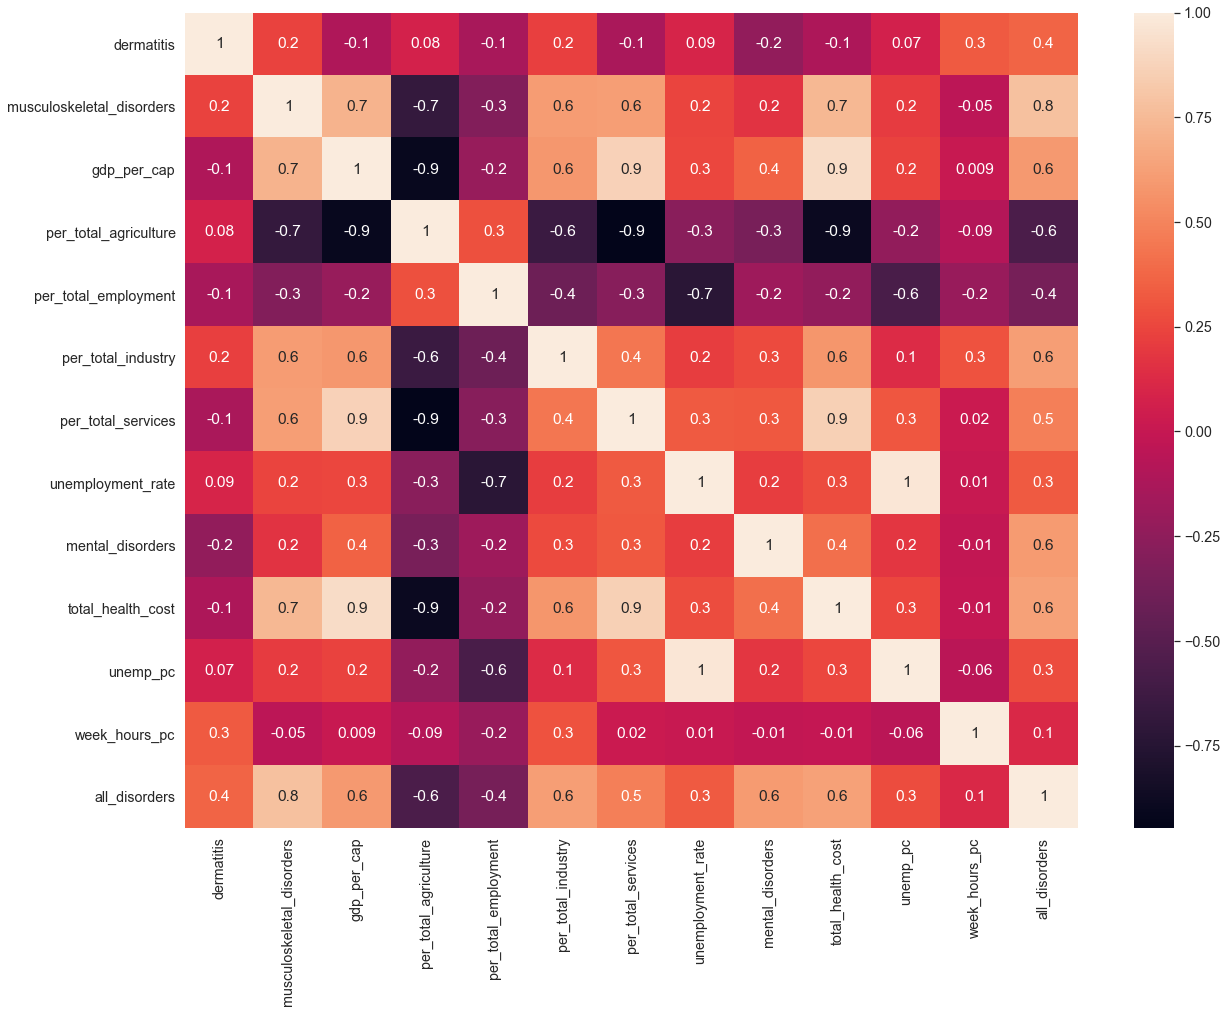

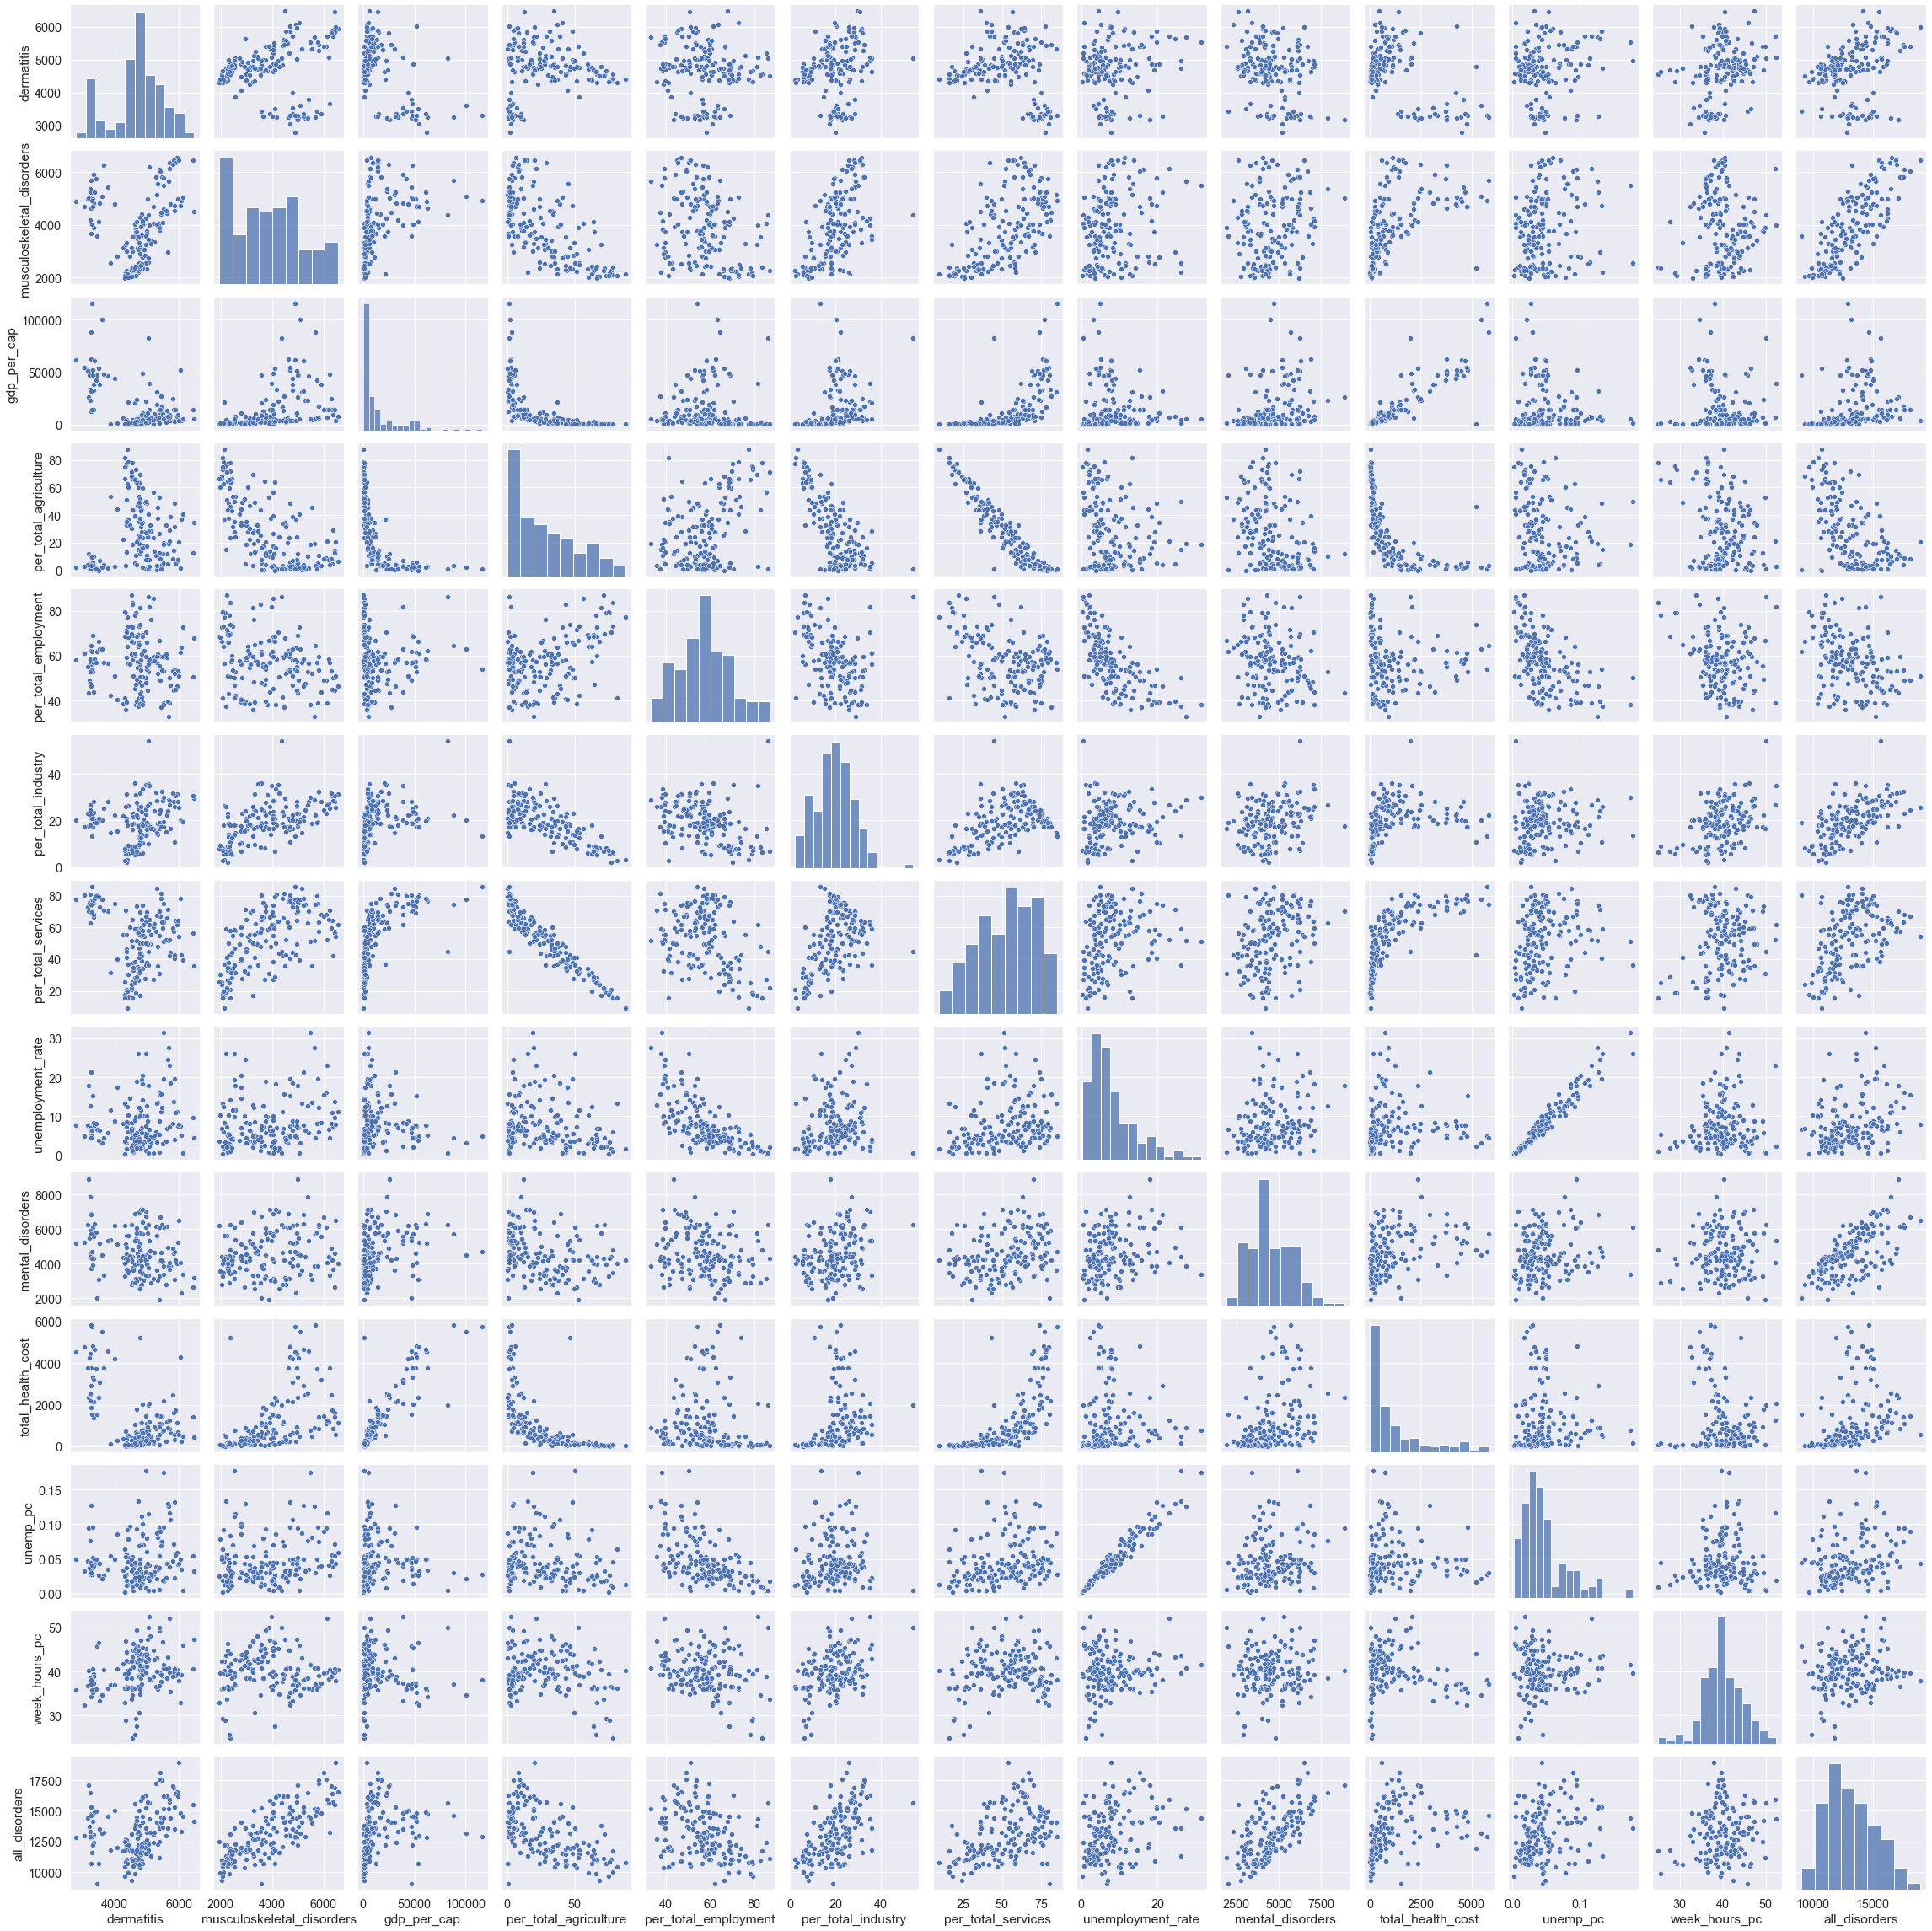

In [45]:
eval_corr(df_11,list(df_11.columns))

### 3.1. Exploracao com as novas variaveis

In [46]:
df_11_feat=df_11

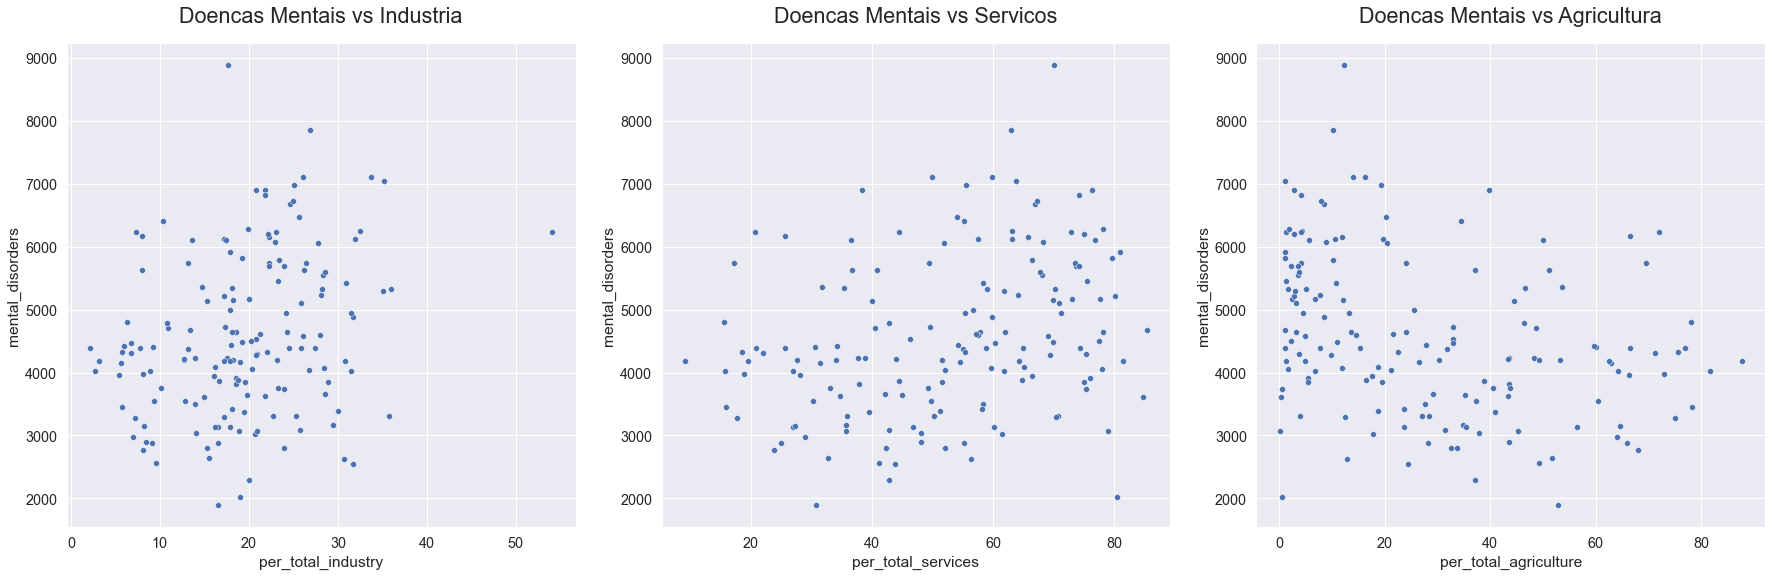

In [47]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 8))
plt.tight_layout(pad=2, w_pad=3, h_pad=1.0)
sns.set(font_scale=1.8)
sns.scatterplot(data=df_11_feat, x='per_total_industry',y= 'mental_disorders', ax=axes[0]).set_title('Doencas Mentais vs Industria')
sns.scatterplot(data=df_11_feat, x='per_total_services',y= 'mental_disorders', ax=axes[1]).set_title('Doencas Mentais vs Servicos')
sns.scatterplot(data=df_11_feat, x='per_total_agriculture',y= 'mental_disorders', ax=axes[2]).set_title('Doencas Mentais vs Agricultura')
plt.savefig('scatter_mental_sector.png', dpi = 200)
plt.show()

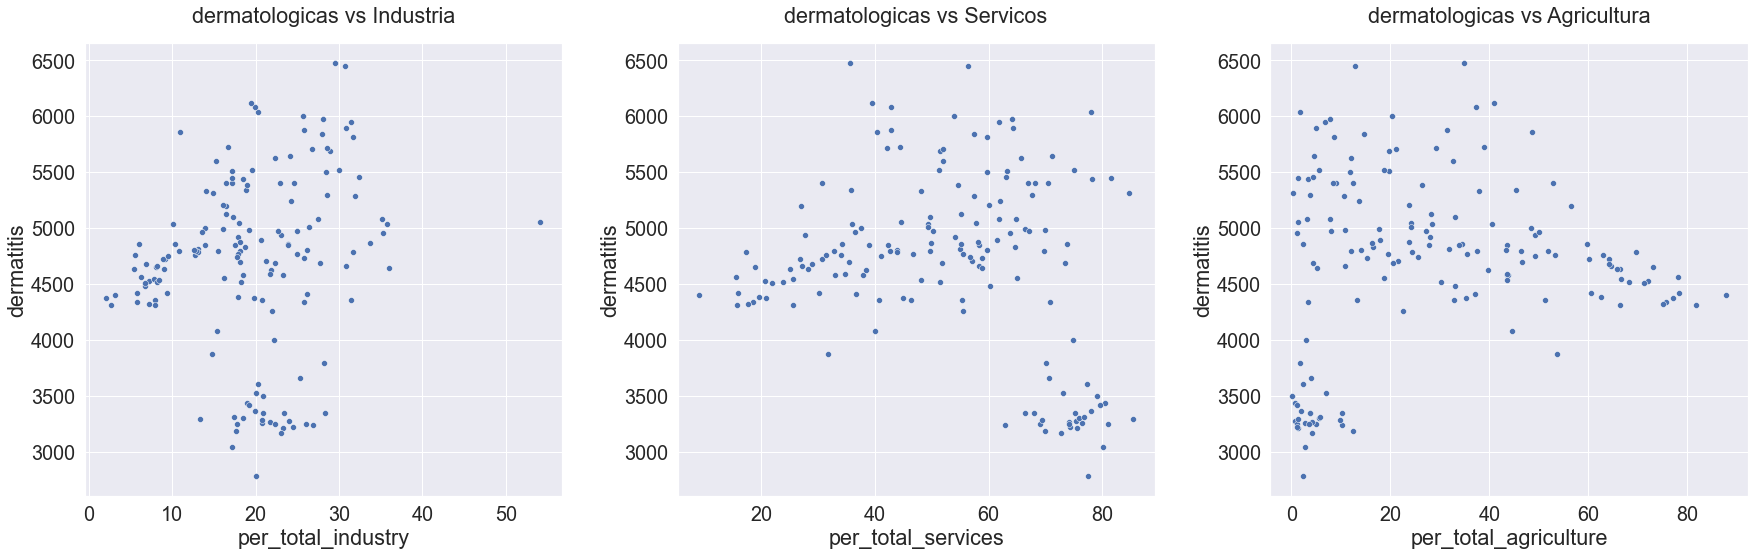

In [48]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 8))
plt.tight_layout(pad=2, w_pad=3, h_pad=1.0)
sns.set(font_scale=1.8)
sns.scatterplot(data=df_11_feat, x='per_total_industry',y= 'dermatitis', ax=axes[0]).set_title('dermatologicas vs Industria')
sns.scatterplot(data=df_11_feat, x='per_total_services',y= 'dermatitis', ax=axes[1]).set_title('dermatologicas vs Servicos')
sns.scatterplot(data=df_11_feat, x='per_total_agriculture',y= 'dermatitis', ax=axes[2]).set_title('dermatologicas vs Agricultura')
plt.savefig('scatter_derm_sector.png', dpi = 200)
plt.show()

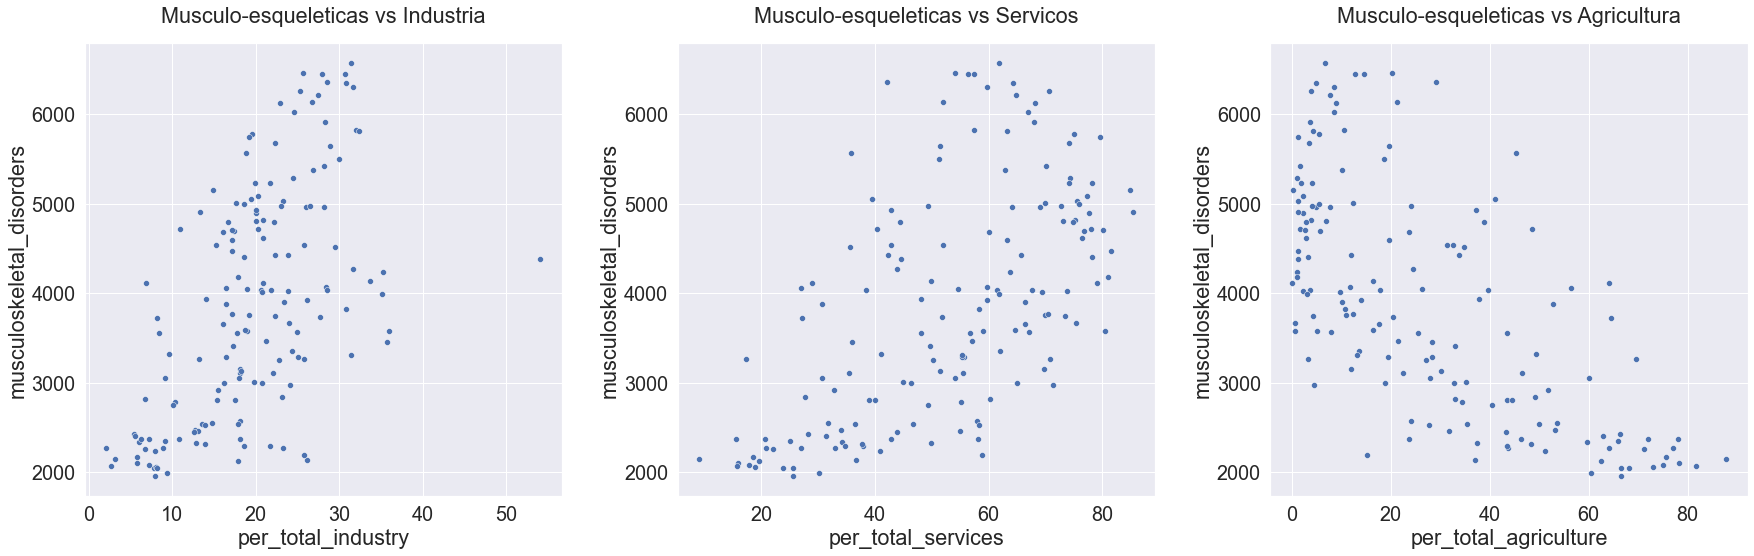

In [49]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 8))
plt.tight_layout(pad=2, w_pad=3, h_pad=1.0)
sns.set(font_scale=1.8)
sns.scatterplot(data=df_11_feat, x='per_total_industry',y= 'musculoskeletal_disorders', ax=axes[0]).set_title('Musculo-esqueleticas vs Industria')
sns.scatterplot(data=df_11_feat, x='per_total_services',y= 'musculoskeletal_disorders', ax=axes[1]).set_title('Musculo-esqueleticas vs Servicos')
sns.scatterplot(data=df_11_feat, x='per_total_agriculture',y= 'musculoskeletal_disorders', ax=axes[2]).set_title('Musculo-esqueleticas vs Agricultura')
plt.savefig('scatter_musc_sector.png', dpi = 200)
plt.show()

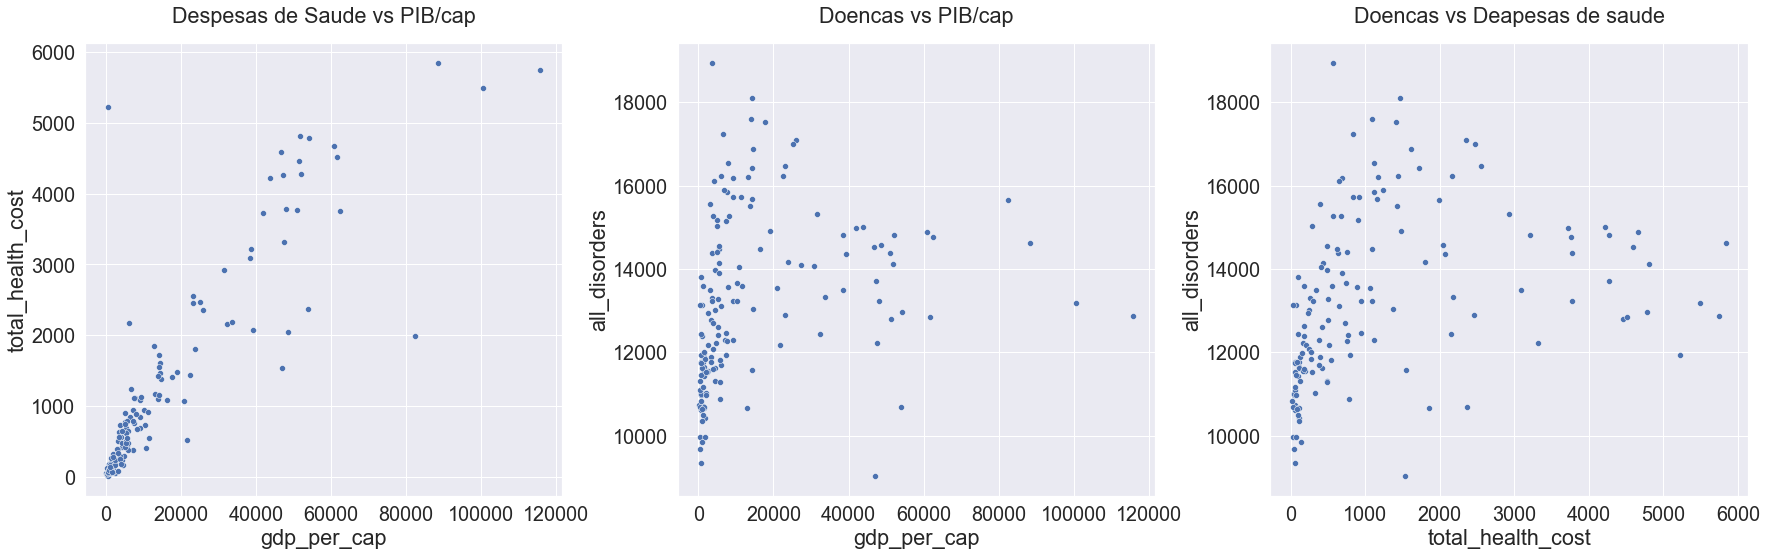

In [50]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 8))
plt.tight_layout(pad=2, w_pad=3, h_pad=1.0)
sns.set(font_scale=1.8)
sns.scatterplot(data=df_11_feat, x='gdp_per_cap',y= 'total_health_cost', ax=axes[0]).set_title('Despesas de Saude vs PIB/cap')
sns.scatterplot(data=df_11_feat, x='gdp_per_cap',y= 'all_disorders', ax=axes[1]).set_title('Doencas vs PIB/cap')
sns.scatterplot(data=df_11_feat, x='total_health_cost',y= 'all_disorders', ax=axes[2]).set_title('Doencas vs Deapesas de saude')
plt.savefig('scatter_all_economics_1.png', dpi = 200)
plt.show()

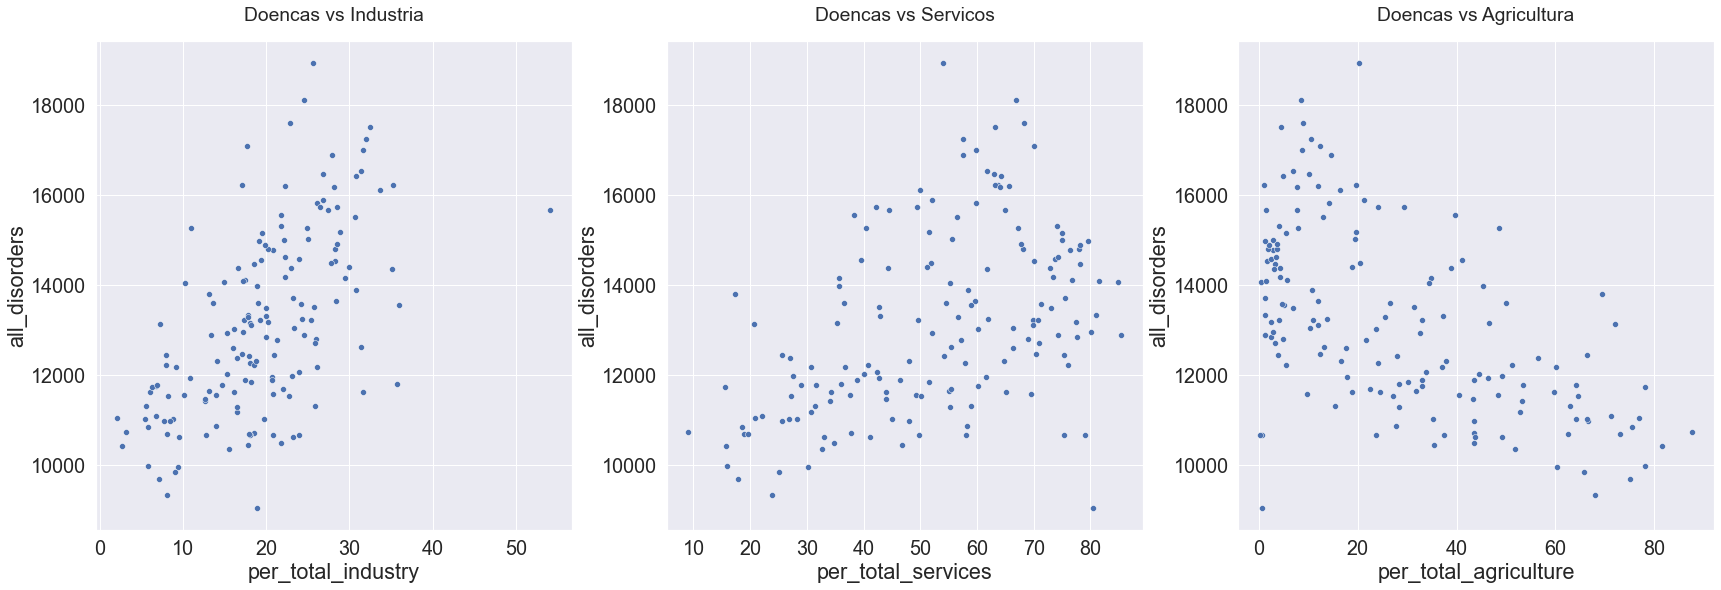

In [51]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(29, 9))
sns.set(font_scale=1.6)
sns.scatterplot(data=df_11_feat, x='per_total_industry',y= 'all_disorders', ax=axes[0]).set_title('Doencas vs Industria')
sns.scatterplot(data=df_11_feat, x='per_total_services',y= 'all_disorders', ax=axes[1]).set_title('Doencas vs Servicos')
sns.scatterplot(data=df_11_feat, x='per_total_agriculture',y= 'all_disorders', ax=axes[2]).set_title('Doencas vs Agricultura')
plt.savefig('scatter_all_sector.png', dpi = 200)
plt.show()

In [52]:
df_11_feat.describe().T

count          mean           std          min  \
dermatitis                 157.0   4685.807259    800.362991  2788.217168   
musculoskeletal_disorders  157.0   3874.012122   1281.833104  1961.084611   
gdp_per_cap                155.0  14849.195812  21038.580011   249.577979   
per_total_agriculture      157.0     27.928917     23.622692     0.110000   
per_total_employment       157.0     57.323885     11.905351    33.090000   
per_total_industry         157.0     19.482102      8.272919     2.130000   
per_total_services         157.0     52.590892     18.614785     9.120000   
unemployment_rate          157.0      8.064204      6.083815     0.320000   
mental_disorders           157.0   4576.799247   1273.609663  1891.259135   
total_health_cost          152.0   1169.524560   1439.035438    18.263212   
unemp_pc                   157.0      0.047101      0.033137     0.002548   
week_hours_pc              157.0     40.035340      4.637888    24.921116   
all_disorders              157.0  13136.618628   2035.091456  9041.484718   

                                    25%           50%           75%  \
dermatitis                  4359.897297   4765.304225   5194.156592   
musculoskeletal_disorders   2786.073003   3764.596187   4813.597457   
gdp_per_cap                 1532.933408   5554.179164  17039.950587   
per_total_agriculture          5.730000     22.570000     43.720001   
per_total_employment          49.279999     57.200001     64.489998   
per_total_industry            14.080000     19.250000     24.959999   
per_total_services            37.840000     55.240002     68.029999   
unemployment_rate              3.770000      6.490000     10.340000   
mental_disorders            3661.111153   4386.985791   5455.438481   
total_health_cost            147.008910    562.994869   1494.632038   
unemp_pc                       0.024947      0.039019      0.055988   
week_hours_pc                 37.129990     39.805248     42.665801   
all_disorders              11568.542317  12938.905149  14551.929738   

                                     max  
dermatitis                   6474.560792  
musculoskeletal_disorders    6569.524981  
gdp_per_cap                115761.507705  
per_total_agriculture          87.750000  
per_total_employment           86.940002  
per_total_industry             54.110001  
per_total_services             85.410004  
unemployment_rate              31.379999  
mental_disorders             8895.963290  
total_health_cost            5841.042480  
unemp_pc                        0.177124  
week_hours_pc                  52.461410  
all_disorders               18936.444518

### 3.2. "Missing Values"

In [53]:
def predict_missing(df, evaluated_column):
    """ Predicts and updates the missing values for the different features. """
    
    cols = list(df.isna().sum()[df.isna().sum() != 0].index)
    
    # removes the evaluated feature
    cols.remove(evaluated_column)
    
    # defines the data to be used using the gradiant boosting method
    gb_data = df.select_dtypes(exclude=['object']).drop(columns = cols)
    
    # divides the data in missing and complete values
    feature_na = gb_data.loc[gb_data[evaluated_column].isna()]
    feature = gb_data.loc[~gb_data[evaluated_column].isna()]
    
    # defines the training data
    x_train = feature.drop(columns = evaluated_column)
    y_train = feature.copy().pop(evaluated_column)
    
    # fits the model
    gb = GradientBoostingRegressor(n_estimators=100)
    gb.fit(x_train, y_train)
    
    # predicts missing values
    x_predict = feature_na.drop(columns = evaluated_column)
    pred = pd.DataFrame(gb.predict(x_predict), index=x_predict.index, columns=[f'{evaluated_column}_na'])
    
    # fills the na values
    df = df.merge(pred, left_index=True, right_index=True, how='left')
    df.loc[df[evaluated_column].isna(), evaluated_column] = df[f'{evaluated_column}_na']
    df.drop(columns = [f'{evaluated_column}_na'], inplace=True)
    
    return df

In [54]:
pd.DataFrame({'#NA: 2011': df_11_feat.isna().sum()})

#NA: 2011
dermatitis                         0
musculoskeletal_disorders          0
gdp_per_cap                        2
per_total_agriculture              0
per_total_employment               0
per_total_industry                 0
per_total_services                 0
unemployment_rate                  0
mental_disorders                   0
total_health_cost                  5
unemp_pc                           0
week_hours_pc                      0
all_disorders                      0

In [55]:
df_11_feat.loc[df_11_feat.isnull().any(axis=1)]

dermatitis  musculoskeletal_disorders   gdp_per_cap  \
location_name                                                                
Guam                  5318.615132                5149.008697  30859.404353   
Montenegro            5523.438917                5773.516912   7329.026063   
Puerto Rico           5449.261183                4469.123640  27278.883050   
Somalia               4316.467890                2070.611927           NaN   
South Sudan           4389.049946                2119.947286   1516.403915   
Syrian Arab Republic  4359.897297                3309.178846           NaN   

                      per_total_agriculture  per_total_employment  \
location_name                                                       
Guam                               0.310000             56.990002   
Montenegro                         5.470000             38.910000   
Puerto Rico                        1.320000             37.009998   
Somalia                           81.680000             41.160000   
South Sudan                       62.529999             63.990002   
Syrian Arab Republic              13.230000             39.509998   

                      per_total_industry  per_total_services  \
location_name                                                  
Guam                           14.920000           84.769997   
Montenegro                     19.549999           74.980003   
Puerto Rico                    17.200001           81.480003   
Somalia                         2.640000           15.680000   
South Sudan                    17.889999           19.580000   
Syrian Arab Republic           31.430000           55.340000   

                      unemployment_rate  mental_disorders  total_health_cost  \
location_name                                                                  
Guam                              13.30       3603.135372                NaN   
Montenegro                        19.67       3854.116690                NaN   
Puerto Rico                       15.70       4177.754035                NaN   
Somalia                           13.38       4023.196109                NaN   
South Sudan                       12.57       4181.216614                NaN   
Syrian Arab Republic               8.60       4953.190408          180.40152   

                      unemp_pc  week_hours_pc  all_disorders  
location_name                                                 
Guam                  0.087434      43.100818   14070.759201  
Montenegro            0.095281      40.858922   15151.072519  
Puerto Rico           0.068939      39.297917   14096.138857  
Somalia               0.063582      36.247212   10410.275926  
South Sudan           0.092012      36.168959   10690.213845  
Syrian Arab Republic  0.037178      42.539269   12622.266550

In [56]:
df_11_gb = (
    df_11_feat
    .pipe(predict_missing, 'total_health_cost')
    .pipe(predict_missing, 'gdp_per_cap')
)

In [57]:
df_11_gb.loc[df_11_feat.isnull().any(axis=1)]
# Gradient Boosting imputed a negative total_health_cost value for Somalia, which should be corrected.
#To simplify the analysis, this line will be removed, along with outliers

dermatitis  musculoskeletal_disorders   gdp_per_cap  \
location_name                                                                
Guam                  5318.615132                5149.008697  30859.404353   
Montenegro            5523.438917                5773.516912   7329.026063   
Puerto Rico           5449.261183                4469.123640  27278.883050   
Somalia               4316.467890                2070.611927    750.659523   
South Sudan           4389.049946                2119.947286   1516.403915   
Syrian Arab Republic  4359.897297                3309.178846   4303.981422   

                      per_total_agriculture  per_total_employment  \
location_name                                                       
Guam                               0.310000             56.990002   
Montenegro                         5.470000             38.910000   
Puerto Rico                        1.320000             37.009998   
Somalia                           81.680000             41.160000   
South Sudan                       62.529999             63.990002   
Syrian Arab Republic              13.230000             39.509998   

                      per_total_industry  per_total_services  \
location_name                                                  
Guam                           14.920000           84.769997   
Montenegro                     19.549999           74.980003   
Puerto Rico                    17.200001           81.480003   
Somalia                         2.640000           15.680000   
South Sudan                    17.889999           19.580000   
Syrian Arab Republic           31.430000           55.340000   

                      unemployment_rate  mental_disorders  total_health_cost  \
location_name                                                                  
Guam                              13.30       3603.135372        2917.791906   
Montenegro                        19.67       3854.116690        1705.295376   
Puerto Rico                       15.70       4177.754035        1220.156105   
Somalia                           13.38       4023.196109         -61.041067   
South Sudan                       12.57       4181.216614         -28.539825   
Syrian Arab Republic               8.60       4953.190408         180.401520   

                      unemp_pc  week_hours_pc  all_disorders  
location_name                                                 
Guam                  0.087434      43.100818   14070.759201  
Montenegro            0.095281      40.858922   15151.072519  
Puerto Rico           0.068939      39.297917   14096.138857  
Somalia               0.063582      36.247212   10410.275926  
South Sudan           0.092012      36.168959   10690.213845  
Syrian Arab Republic  0.037178      42.539269   12622.266550

### 3.3. Lidando com Outliers

In [58]:
def eval_outliers(df,columns):
    # check distribution of feature with highest kurtosis/skewness
    fig, axes = plt.subplots(1,len(columns), figsize = (14,6))
    for i,col_name in enumerate(columns):
        sns.boxplot(ax = axes[i], data = df, x = col_name).set(title=col_name)
    plt.show()
    
    return pd.DataFrame({'skew':df.skew(),'kurt':df.kurt()})

#### 3.3.1 Avaliacao e remocao de Outliers

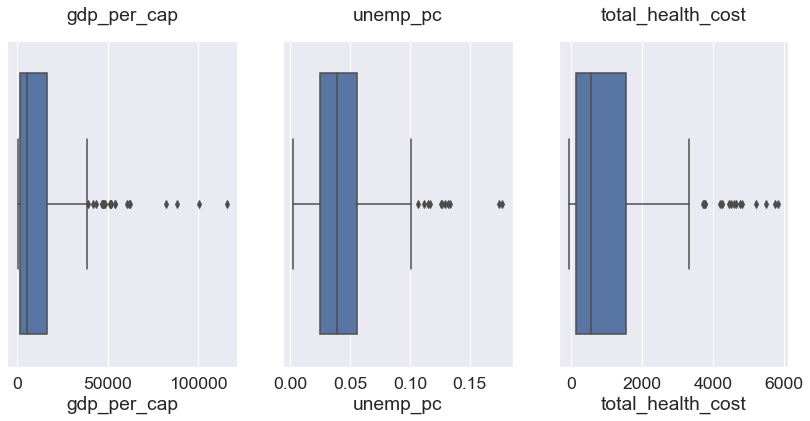

skew      kurt
dermatitis                -0.361964 -0.284530
musculoskeletal_disorders  0.307942 -0.931164
gdp_per_cap                2.238861  5.522765
per_total_agriculture      0.653955 -0.703915
per_total_employment       0.285899 -0.274244
per_total_industry         0.329752  0.970704
per_total_services        -0.306074 -0.893237
unemployment_rate          1.412328  1.929349
mental_disorders           0.466218 -0.003642
total_health_cost          1.617877  1.772574
unemp_pc                   1.440331  2.288144
week_hours_pc             -0.197083  1.085889
all_disorders              0.428805 -0.443135

In [59]:
eval_outliers(df_11_gb,['gdp_per_cap','unemp_pc','total_health_cost'])
#In total_health_cost, the observations after Q3 are not much separated from each other, so we will not remove them
#In both GDP_PC and Unemp_PC, we can visually observe a big separation between the extreme points and the remaining

In [60]:
pd.concat([df_11_gb.loc[df_11_gb.unemp_pc > 0.15],df_11_gb.loc[df_11_gb.gdp_per_cap > 75000],df_11_gb.loc[df_11_gb.total_health_cost < 0]])

dermatitis  musculoskeletal_disorders    gdp_per_cap  \
location_name                                                            
Lesotho          4963.937157                2533.258411    1308.690069   
North Macedonia  5524.033277                5497.728910    5063.786986   
Luxembourg       3291.846818                4910.542012  115761.507705   
Norway           3604.407771                5091.140820  100600.562408   
Qatar            5052.915012                4378.810274   82409.577333   
Switzerland      3253.039580                5676.299312   88415.628032   
Somalia          4316.467890                2070.611927     750.659523   
South Sudan      4389.049946                2119.947286    1516.403915   

                 per_total_agriculture  per_total_employment  \
location_name                                                  
Lesotho                      49.959999             50.310001   
North Macedonia              18.740000             38.060001   
Luxembourg                    1.230000             54.070000   
Norway                        2.370000             63.110001   
Qatar                         1.360000             86.330002   
Switzerland                   3.510000             64.489998   
Somalia                      81.680000             41.160000   
South Sudan                  62.529999             63.990002   

                 per_total_industry  per_total_services  unemployment_rate  \
location_name                                                                
Lesotho                   13.570000           36.470001          26.040001   
North Macedonia           30.000000           51.259998          31.379999   
Luxembourg                13.360000           85.410004           4.900000   
Norway                    20.250000           77.379997           3.220000   
Qatar                     54.110001           44.540001           0.560000   
Switzerland               22.280001           74.209999           4.400000   
Somalia                    2.640000           15.680000          13.380000   
South Sudan               17.889999           19.580000          12.570000   

                 mental_disorders  total_health_cost  unemp_pc  week_hours_pc  \
location_name                                                                   
Lesotho               6102.558954         174.807991  0.177124      39.688237   
North Macedonia       3383.652053         748.700623  0.174065      41.482930   
Luxembourg            4678.384870        5746.539917  0.027856      38.060179   
Norway                4493.084254        5492.077148  0.020994      34.589620   
Qatar                 6230.564578        1984.346008  0.004862      50.033183   
Switzerland           5698.514422        5841.042480  0.029682      37.122342   
Somalia               4023.196109         -61.041067  0.063582      36.247212   
South Sudan           4181.216614         -28.539825  0.092012      36.168959   

                 all_disorders  
location_name                   
Lesotho           13599.754522  
North Macedonia   14405.414241  
Luxembourg        12880.773699  
Norway            13188.632845  
Qatar             15662.289864  
Switzerland       14627.853314  
Somalia           10410.275926  
South Sudan       10690.213845

In [61]:
index_2_remove = pd.concat([df_11_gb.loc[df_11_gb.unemp_pc > 0.15],df_11_gb.loc[df_11_gb.gdp_per_cap > 75000],df_11_gb.loc[df_11_gb.total_health_cost < 0]]).index
df_11_no = df_11_gb.drop(index = list(index_2_remove))

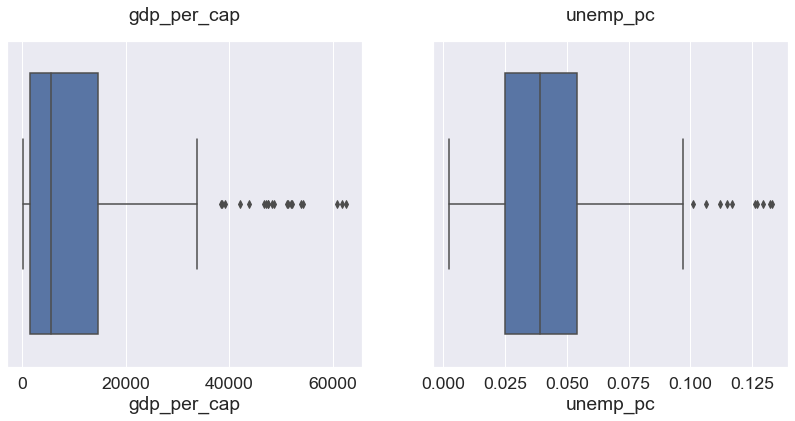

skew      kurt
dermatitis                -0.382522 -0.190846
musculoskeletal_disorders  0.354616 -0.854119
gdp_per_cap                1.597629  1.387569
per_total_agriculture      0.650061 -0.681022
per_total_employment       0.261446 -0.304850
per_total_industry        -0.078445 -0.593575
per_total_services        -0.328279 -0.871773
unemployment_rate          1.278478  1.369834
mental_disorders           0.487820  0.020941
total_health_cost          1.564517  1.544267
unemp_pc                   1.126306  0.778539
week_hours_pc             -0.286219  1.158288
all_disorders              0.456597 -0.433701

In [62]:
#Re-evaluate whiskers, skew and kurt:
eval_outliers(df_11_no,['gdp_per_cap','unemp_pc'])

## 4. Clusterizacao

### 4.1. Funcoes para clusterizacao

In [63]:
def pt_evaluation(df, evaluated_column):
    """ Evaluates the defined feature before and after applying power transformation. """
    
    # defining the power transformation class
    pt = PowerTransformer()

    # creating the evaluation data frame
    feature = df[[evaluated_column]]
    feature = feature.assign(log_transformation = np.log(feature[evaluated_column] + 1))
    feature = feature.assign(sqrt_transformation = np.sqrt(feature[evaluated_column]))
    feature = feature.assign(cbrt_transformation = np.cbrt(feature[evaluated_column]))
    #feature = feature.assign(yeo_johnson = pt.fit_transform(np.array(feature[evaluated_column]).reshape(-1, 1)))
    
    # represent the data
    fig, axes = plt.subplots(1, 4, figsize=(25, 6))
    sns.histplot(data=feature, x=evaluated_column,  ax=axes[0])
    sns.histplot(data=feature, x='sqrt_transformation', ax=axes[1], legend=False)
    sns.histplot(data=feature, x='cbrt_transformation', ax=axes[2], legend=False)
    sns.histplot(data=feature, x='log_transformation', ax=axes[3], legend=False)
    #sns.histplot(data=feature, x='yeo_johnson', ax=axes[4], legend=False)

In [64]:
def evaluate_number_clusters(df, n):
    """ Evaluates the kmeans using different values of k. """
    
    # evalaution result list
    evaluation = []
    
    # evaluates different number of clusters
    for k in range(2, n):    

        # performs the kmeans cluster using the defined number of clusters
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        silhoutte_score = silhouette_score(df, kmeans.labels_)

        # appends the results to the 
        evaluation.append([k, kmeans.inertia_, silhoutte_score])

    # converts the evaluation do df
    evaluation = pd.DataFrame(evaluation, columns=['k', 'error', 'silhouette'])

    # plots the evaluation
    fig, axes = plt.subplots(2,1, figsize = (14,6))
    sns.lineplot(data=evaluation, x='k', y='error', ax=axes[0], markers=True, marker="o")
    sns.lineplot(data=evaluation, x='k', y='silhouette', ax=axes[1], markers=True, marker="o")
    
    # saves the evaluation
    #fig.savefig(f'{prefix}_number_of_clusters_evaluation.png')

In [65]:
def evaluate_cluster(df_cluster, df_evaluate, k):
    """ Evaluate a specific number of cluster. """ 
    
    # applies the kmeans with specific number of clusters
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster)
    labels = kmeans.labels_
    
    # updates the cluster data
    df_cluster = df_cluster.assign(cluster = labels)
    
    # defines the number of columns to be evaluated
    columns = df_cluster.columns[:-1]
    n_columns = len(columns)
    
    # defines the standard height and width of the graphs
    graph_height = 6
    praph_width = 6
    
    # defines the number of columns and rows to be ploted
    n_columns_subplot = n_columns if n_columns <= 3 else 3
    if n_columns // 3 == 0 and n_columns != 3:
         n_rows_subplot = 1
    elif n_columns // 3 != 0 and n_columns % 3 == 0:
        n_rows_subplot = n_columns // 3 
    else:
        n_rows_subplot = n_columns // 3 + 1

    # calculates the total heigh and width
    total_height = graph_height * n_rows_subplot
    total_width = praph_width * n_columns_subplot
    
    # creates the subplot structure
    fig, axes = plt.subplots(n_rows_subplot, n_columns_subplot, figsize=(total_width, total_height))
    
    # defines the initial axis location of the plots
    if n_rows_subplot == 1:
        p = 0
    else:
        r = 0
        c = 0
    
    # plots all the columns
    for column in columns:
        if n_rows_subplot == 1:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[p], fill=True)
            p += 1
        else:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[r, c], fill=True)
            if c == n_columns_subplot-1:
                r += 1
                c = 0
            else:
                c += 1
            
    # saves the plot
    
    # shows the plot
    plt.show()
    
    # updates the evalutiaon data
    df_evaluate = df_evaluate.assign(labels=kmeans.labels_)
    
    return df_evaluate, kmeans

In [66]:
def agreg_clusters(df_evaluate):  
    metrics = {'labels': 'count'}
    for column in df_evaluate.columns:
        if column != 'labels':
            #metrics[column] = ['mean', 'median']
            metrics[column] = ['mean']
    df = df_evaluate.groupby('labels').agg(metrics).round(2)
    return df

In [67]:
def plot_clusters_correlations(df,file_name, x="", dimensions="", color="", shape = None):
    """
        plot set of boxplot rows and cols based on input 
    """
    n_cols = 2
    n_rows = math.ceil(len(dimensions) / n_cols)
    
    palette ={0: '#7fc97f', 1: "#fdc086", 2: "#386cb0", 3:'#bf5b17', 4:'#666666'}
    
    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(18, n_rows * 6))
    plt.tight_layout(pad=2, w_pad=3, h_pad=1.0)
    
    
    row = 0
    col = 0
    for dim in dimensions:
        
        sns.boxplot(ax=axes[row, col], x = x, y=dim, data = df,palette = palette).set(xlabel='cluster')

        if col % 2:
            row += 1
            col = 0
        else:
            col += 1
        
    for ax in fig.axes:
        ax.tick_params(labelrotation=0)
   
    file_name = file_name + '.png'
    plt.savefig(file_name, dpi = 500)
    
    plt.show()
    
    return fig

###  __Ano de  2011__, considerando as seguintes variaveis:

1. __per_total_employment__
2. __Week_hours_PC__
3. __GDP_PC__
4. __All_disorders__



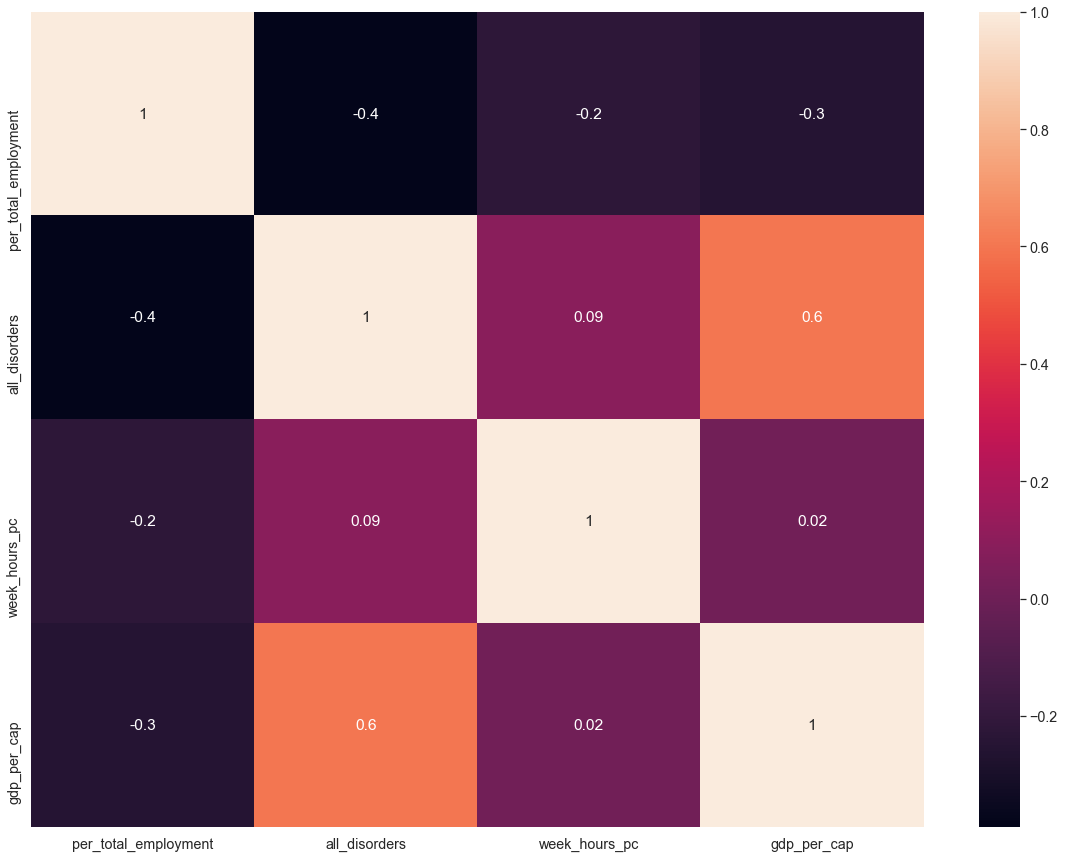

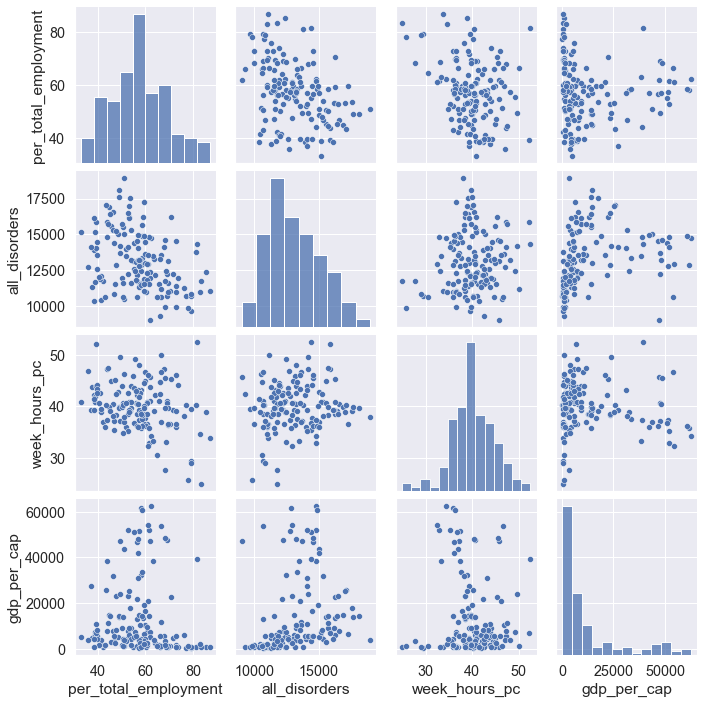

In [68]:
cols_eval = ['per_total_employment','all_disorders', 'week_hours_pc','gdp_per_cap']

eval_corr(df_11_no,cols_eval)

In [69]:
df_sc_1 = df_11_no[cols_eval]

### 4.2. Tranformacao de variaveis

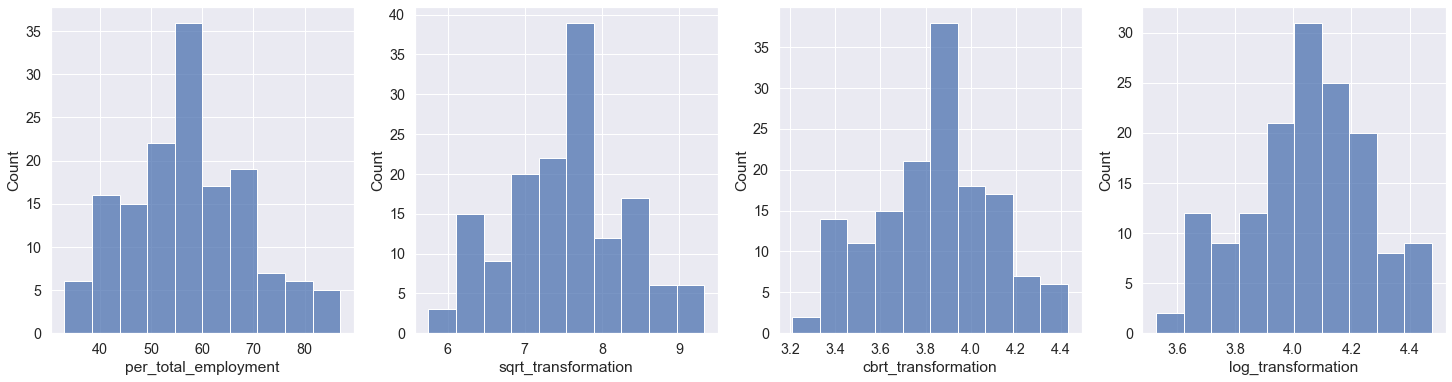

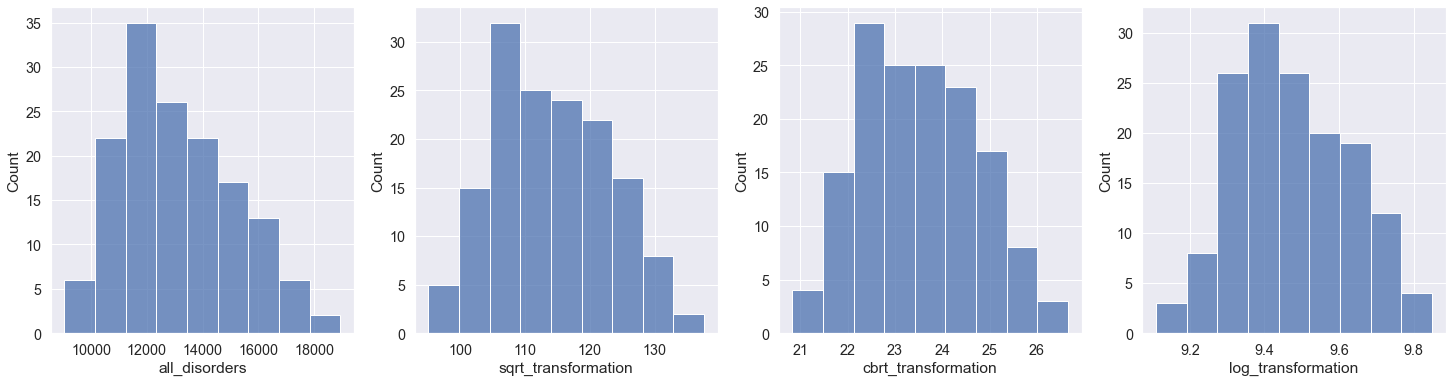

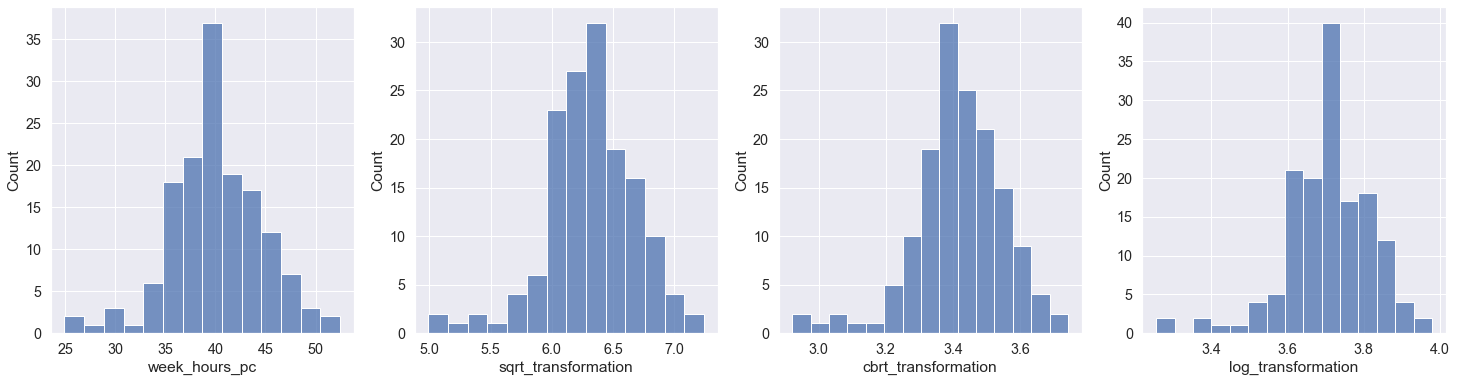

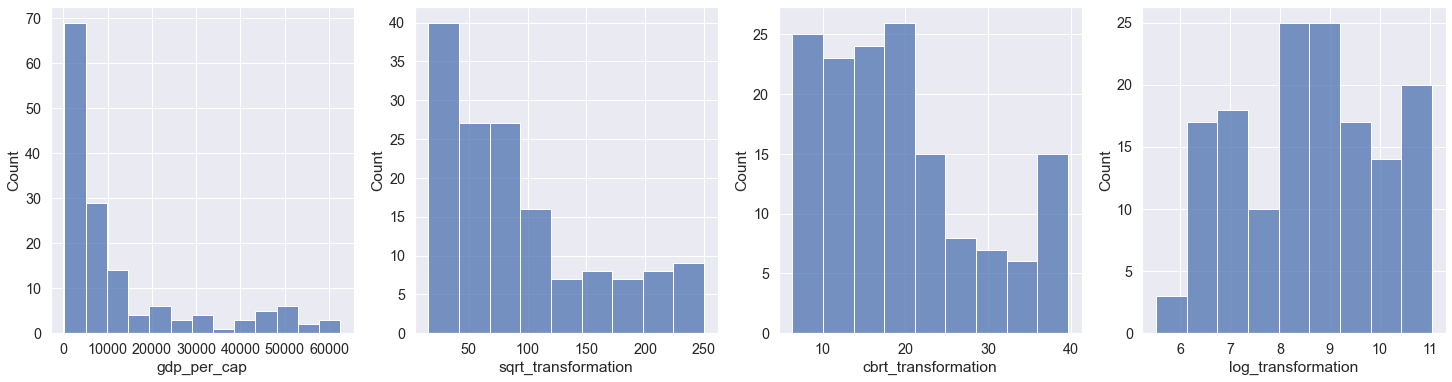

In [70]:
pt_evaluation(df_sc_1, 'per_total_employment')
pt_evaluation(df_sc_1, 'all_disorders')
pt_evaluation(df_sc_1, 'week_hours_pc')
pt_evaluation(df_sc_1, 'gdp_per_cap')

In [71]:
df_sc1_t = df_sc_1[[]]
df_sc1_t = df_sc1_t.assign(per_total_employment_cb = np.cbrt(df_sc_1['per_total_employment']))
df_sc1_t = df_sc1_t.assign(all_disorders_cb = np.cbrt(df_sc_1['all_disorders']))
df_sc1_t = df_sc1_t.assign(Week_hours_PC_norm = (df_sc_1['week_hours_pc']))
df_sc1_t = df_sc1_t.assign(GDP_PC_norm = np.log(df_sc_1['gdp_per_cap']+1))

<AxesSubplot:>

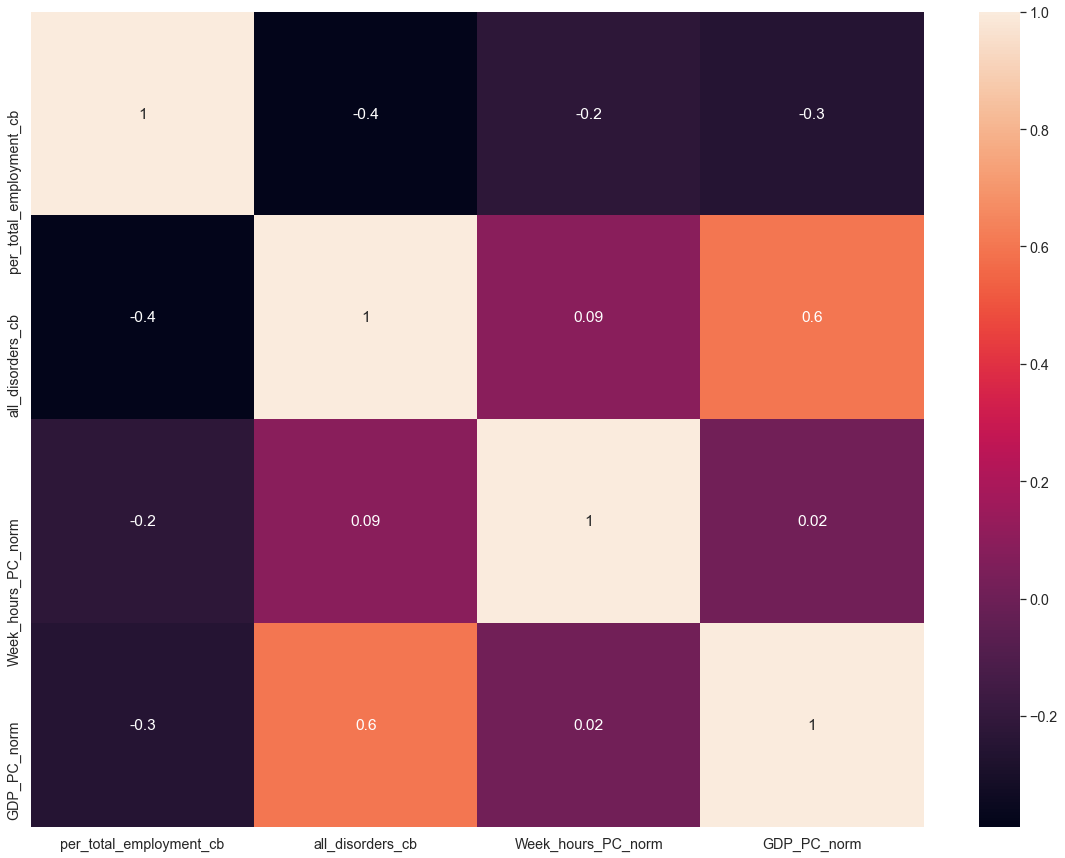

In [72]:
# Verificar correlacao entre as variaveis transformadas:

sns.set(font_scale=1.3)
df_corr = df_sc1_t.corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g')

### 4.3. K-means

In [73]:
#escalamento dos dados transformados
minmax = MinMaxScaler()
minmax_sc1 = pd.DataFrame(minmax.fit_transform(df_sc1_t), columns=df_sc1_t.columns)

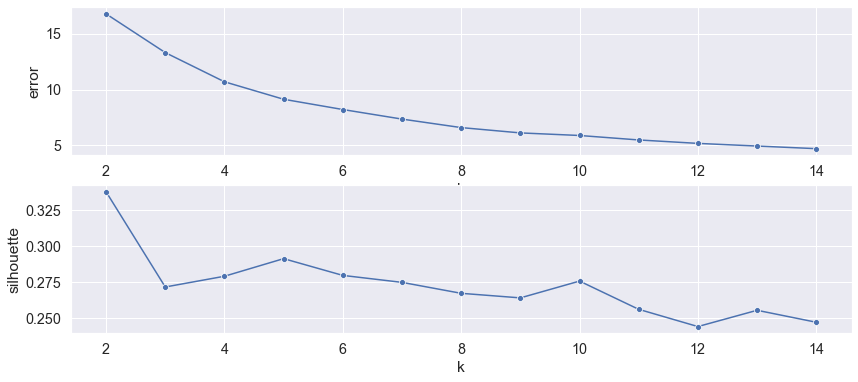

In [74]:
#escolha do numero de clusters
evaluate_number_clusters(minmax_sc1,15)

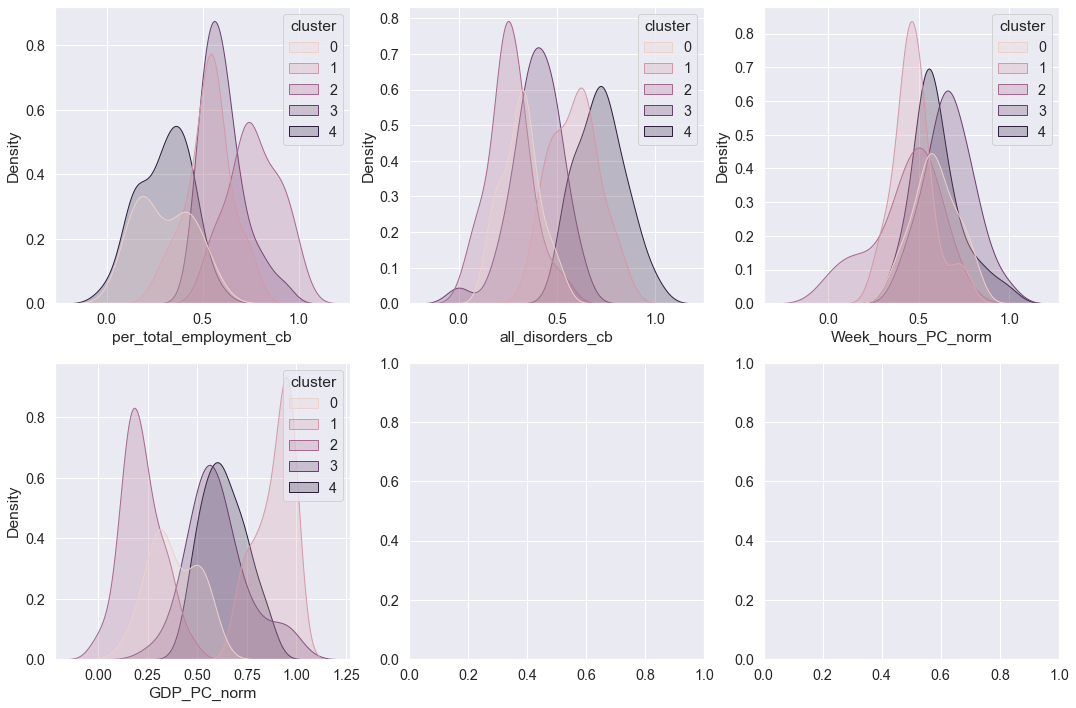

In [75]:
#geracao dos clusters & visualizacao da distribuicao de cada um (K=5)
df_cluster_11, kmeans = evaluate_cluster(minmax_sc1, df_sc_1, 5)

In [76]:
#descricao dos clusters por media e mediana
agreg_clusters(df_cluster_11)

labels per_total_employment all_disorders week_hours_pc gdp_per_cap
        count                 mean          mean          mean        mean
labels                                                                    
0          22                46.02      11650.61         41.13     2497.26
1          31                57.63      14318.15         37.86    37373.85
2          31                71.52      11179.44         36.59      978.39
3          34                61.68      12428.08         43.35    10543.42
4          31                45.97      15731.95         41.46     9952.19

In [77]:
df_aggreg_11 = agreg_clusters(df_cluster_11)
df_aggreg_11 = pd.DataFrame({
    'taxa de emprego [%]': df_aggreg_11[('per_total_employment','mean')],
    'doencas [/100k habs]':df_aggreg_11[('all_disorders','mean')],
    'PIB [$/cap]': df_aggreg_11[('gdp_per_cap','mean')],
    'horas de trabalho [/sem]': df_aggreg_11[('week_hours_pc','mean')]
    })
df_aggreg_11['cluster'] = ['0','1','2','3','4']

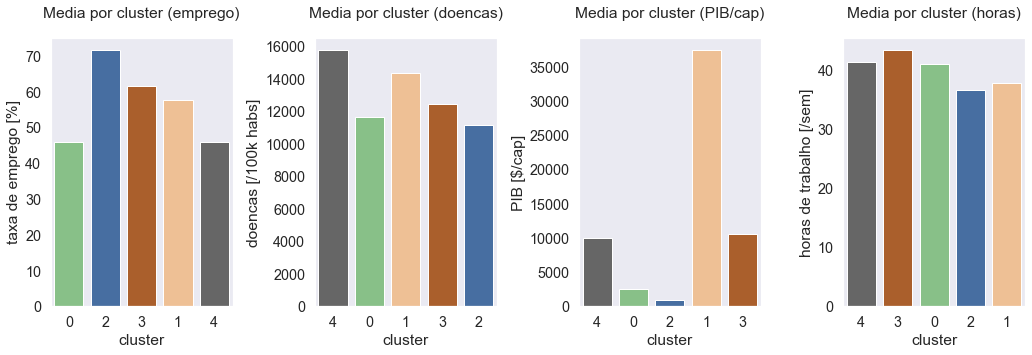

In [78]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
plt.tight_layout(pad=2, w_pad=2.5, h_pad=1.0)
palette ={"0": '#7fc97f', "1": "#fdc086", "2": "#386cb0", '3':'#bf5b17', '4':'#666666'}
sns.barplot(x="cluster", y="taxa de emprego [%]",order =['0','2','3','1','4'], data=df_aggreg_11,ax = axes[0],palette = palette).set_title('Media por cluster (emprego)')
sns.barplot(x="cluster", y="doencas [/100k habs]",order =['4','0','1','3','2'], data=df_aggreg_11,ax = axes[1],palette = palette).set_title('Media por cluster (doencas)')
sns.barplot(x="cluster", y="PIB [$/cap]",order =['4','0','2','1','3'], data=df_aggreg_11,ax = axes[2],palette = palette).set_title('Media por cluster (PIB/cap)')
sns.barplot(x="cluster", y="horas de trabalho [/sem]",order =['4','3','0','2','1'], data=df_aggreg_11,ax = axes[3],palette = palette).set_title('Media por cluster (horas)')
for i in range(0,4):
    axes[i].grid(False)

#plt.savefig('cluster_eval.png', dpi = 500)
plt.show()

### 4.4. Caracterizacao dos clusters (outras variaveis)

In [79]:
df_others = pd.concat([df_11_no[['per_total_agriculture','per_total_industry','per_total_services',\
                                 'musculoskeletal_disorders','dermatitis','mental_disorders']],\
                       df_cluster_11['labels']], axis=1)

df_others.rename(columns={'per_total_agriculture':'Agricultura [%]','per_total_industry':'Industria[%]',\
                      'per_total_services':'Servicos [%]','musculoskeletal_disorders':\
                      'Doencas Musculo-esqueleticas [/100k habs]','dermatitis':'Doencas dermatologicas [/100k habs]'\
                  ,'mental_disorders':'Disturbios mentais [/100k habs]'}, inplace=True)
    
#add color code through palette:
palette ={0: '#7fc97f', 1: "#fdc086", 2: "#386cb0", 3:'#bf5b17', 4:'#666666'}

df_others['Cluster_Color'] = df_others['labels'].map(palette)

df_others_agg = df_others.groupby('labels').agg('mean').round(2)

In [80]:
df_others_agg

Agricultura [%]  Industria[%]  Servicos [%]  \
labels                                                
0                 34.44         19.37         46.19   
1                  4.84         22.79         72.37   
2                 61.17          9.84         29.00   
3                 24.17         20.13         55.70   
4                 17.35         24.59         58.06   

        Doencas Musculo-esqueleticas [/100k habs]  \
labels                                              
0                                         3019.48   
1                                         4948.58   
2                                         2523.96   
3                                         3611.70   
4                                         5002.15   

        Doencas dermatologicas [/100k habs]  Disturbios mentais [/100k habs]  
labels                                                                        
0                                   4693.11                          3938.01  
1                                   3997.73                          5371.84  
2                                   4609.78                          4045.70  
3                                   4888.73                          3927.66  
4                                   5321.88                          5407.93

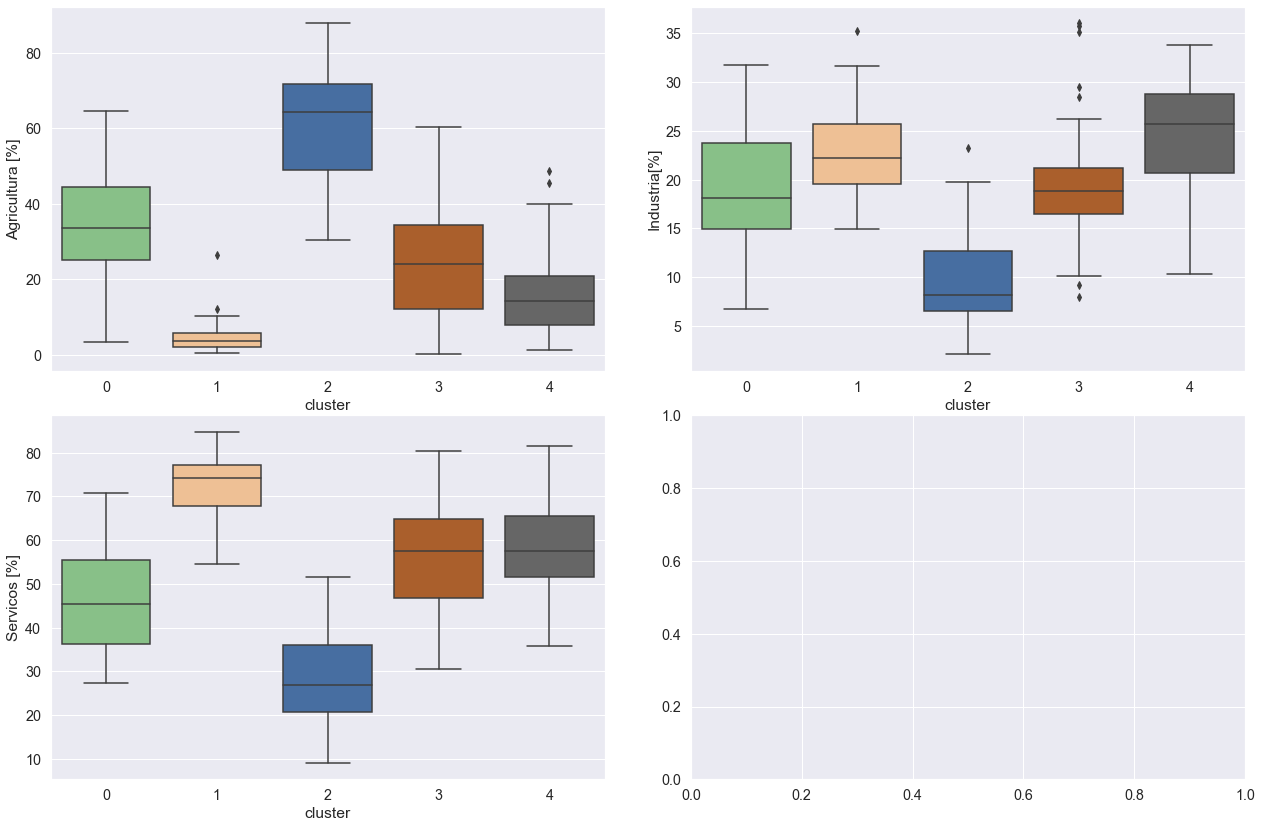

In [81]:
_fig = plot_clusters_correlations(df_others,'sectors','labels',[
                                        'Agricultura [%]', 
                                        'Industria[%]',
                                        'Servicos [%]',
                                       ])

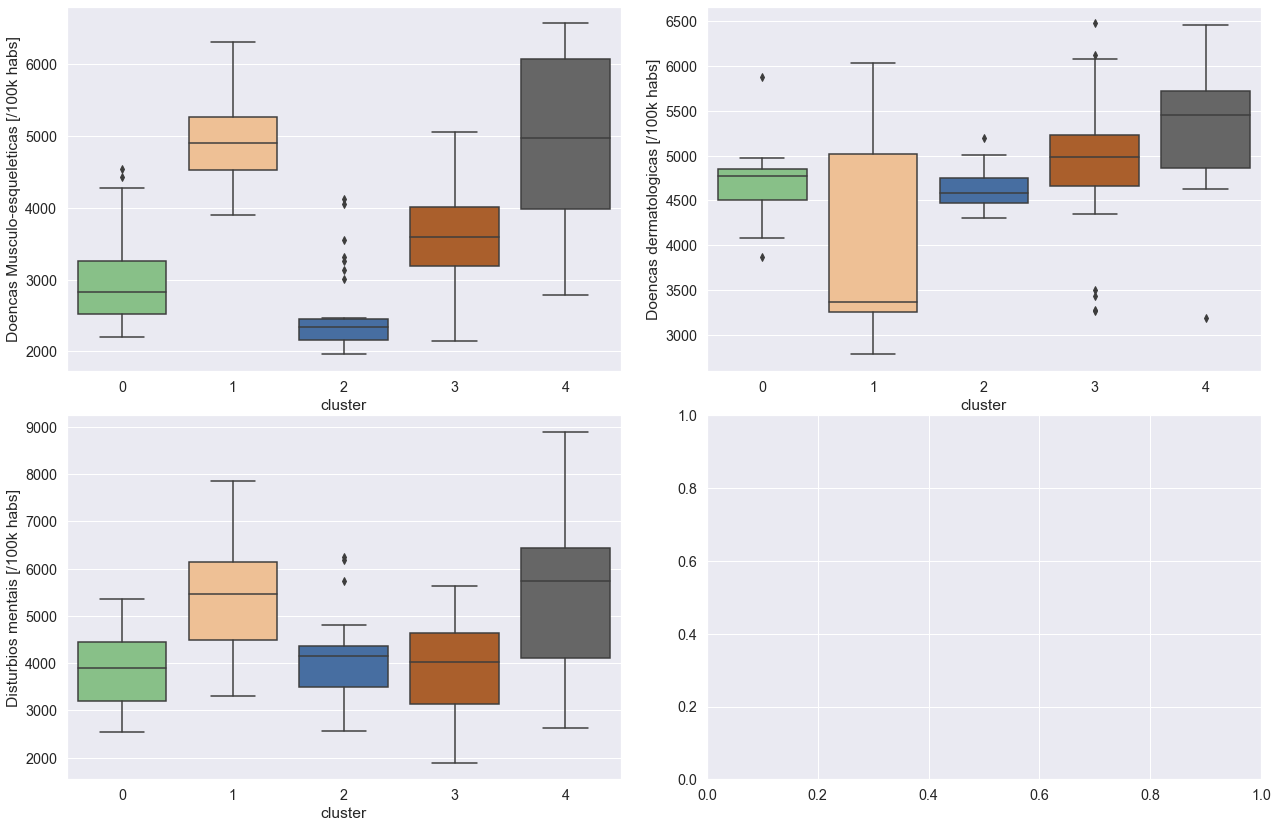

In [82]:
_fig = plot_clusters_correlations(df_others,'diseases','labels',[
                                        'Doencas Musculo-esqueleticas [/100k habs]', 
                                        'Doencas dermatologicas [/100k habs]',
                                        'Disturbios mentais [/100k habs]',
                                       ])

### 4.5. Comparacao entre 2011 e 2017

In [83]:
df_17_feat = get_by_year('2017',country_list = [], drop_col = False).drop(columns='year')


In [84]:
df_17_feat = df_17_feat[[
       'dermatitis', 'musculoskeletal_disorders', 
        'gdp_per_cap', 
        'per_total_agriculture',
        'per_total_employment',
        'per_total_industry',
         'per_total_services',
        'unemployment_rate',
      'mental_disorders', 'total_health_cost', 'unemp_pc',
       'week_hours_pc', 'all_disorders']]

In [85]:
pd.DataFrame({'#NA: 2017': df_17_feat.isna().sum()})

#NA: 2017
dermatitis                         0
musculoskeletal_disorders          0
gdp_per_cap                        3
per_total_agriculture              0
per_total_employment               0
per_total_industry                 0
per_total_services                 0
unemployment_rate                  0
mental_disorders                   0
total_health_cost                  6
unemp_pc                           0
week_hours_pc                      1
all_disorders                      0

In [86]:
#Missing Values
df_17_gb = (
    df_17_feat
    .pipe(predict_missing, 'total_health_cost')
    .pipe(predict_missing, 'gdp_per_cap')
    .pipe(predict_missing, 'week_hours_pc')
) ## Fill missing values using GB again

In [87]:
#index_2_remove are the countries removed in the df of 2011. Thse are also going to be removed in 2017
df_17_no = df_17_gb.drop(index = list(index_2_remove))

In [88]:
cols_eval = ['per_total_employment','all_disorders', 'week_hours_pc','gdp_per_cap']
df_sc_2 = df_17_no[cols_eval] ## reduce df to the variables used in this clustering analysis

In [89]:
## Use the same transformations as in 2011
df_sc2_t = df_sc_2[[]]
df_sc2_t = df_sc2_t.assign(per_total_employment_cb = np.cbrt(df_sc_2['per_total_employment']))
df_sc2_t = df_sc2_t.assign(all_disorders_cb = np.cbrt(df_sc_2['all_disorders']))
df_sc2_t = df_sc2_t.assign(Week_hours_PC_norm = (df_sc_2['week_hours_pc']))
df_sc2_t = df_sc2_t.assign(GDP_PC_log = np.log(df_sc_2['gdp_per_cap']+1))

In [90]:
minmax = MinMaxScaler()
minmax_sc2 = pd.DataFrame(minmax.fit_transform(df_sc2_t), columns=df_sc2_t.columns)

In [91]:
## "Predict" which cluster does each 2011 sample belongs to (in terms of 2017 clsuters)
clusters_2 = kmeans.predict(minmax_sc2, sample_weight=None)
df_cluster_2 = df_sc_2.assign(labels = clusters_2)

## 5. Representacao Geografica dos clusters

In [92]:
def get_country_code(df):
    
    #reassign years as new columns
    
    df = df[['Country Code','Country Name']].copy()
    df.rename(columns={'Country Code':'Country_Code'},inplace=True)
    df.drop_duplicates(inplace=True)
    df.set_index('Country Name', inplace = True)
    df = df.rename_axis('location_name')
    return df

In [93]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [94]:
def build_geo_df(df_world,df_cluster,df_pop,year):
    
    df = df_world.copy()
    
    #Replace wrong code countries
    df['iso_a3'][df.name == 'France'] = df['iso_a3'][df.name == 'France'].replace({'-99':'FRA'})
    df['iso_a3'][df.name == 'Norway'] = df['iso_a3'][df.name == 'Norway'].replace({'-99':'NOR'})
    df['iso_a3'][df.name == 'Kosovo'] = df['iso_a3'][df.name == 'Kosovo'].replace({'-99':'XKX'})

    df_code = pd.merge(get_country_code(df_pop),df_cluster, on='location_name',\
                   how='inner')[['Country_Code','labels']]
    
    df_code.set_index('Country_Code',inplace=True)
    
    df.set_index('iso_a3',inplace=True)
    
    df = df.rename_axis('Country_Code')
    
    geo_df = pd.merge(df,df_code,on='Country_Code',how='inner')
    

    ax = geo_df.plot(column='labels', categorical=True, legend=True, \
                 legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),
                             'fmt': "{:.0f}",'title':'cluster label'},figsize=(40, 40),cmap ="Accent").set_title('World Countries by Cluster')
    
    

    plt.grid(b=None)
    plt.axis('off')
    pic_name = 'world_'+ year + '_.png'
   # plt.savefig(pic_name, dpi = 600)
    plt.show()

<ipython-input-94-6ea5e66cf8a4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3'][df.name == 'France'] = df['iso_a3'][df.name == 'France'].replace({'-99':'FRA'})
<ipython-input-94-6ea5e66cf8a4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3'][df.name == 'Norway'] = df['iso_a3'][df.name == 'Norway'].replace({'-99':'NOR'})
<ipython-input-94-6ea5e66cf8a4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3

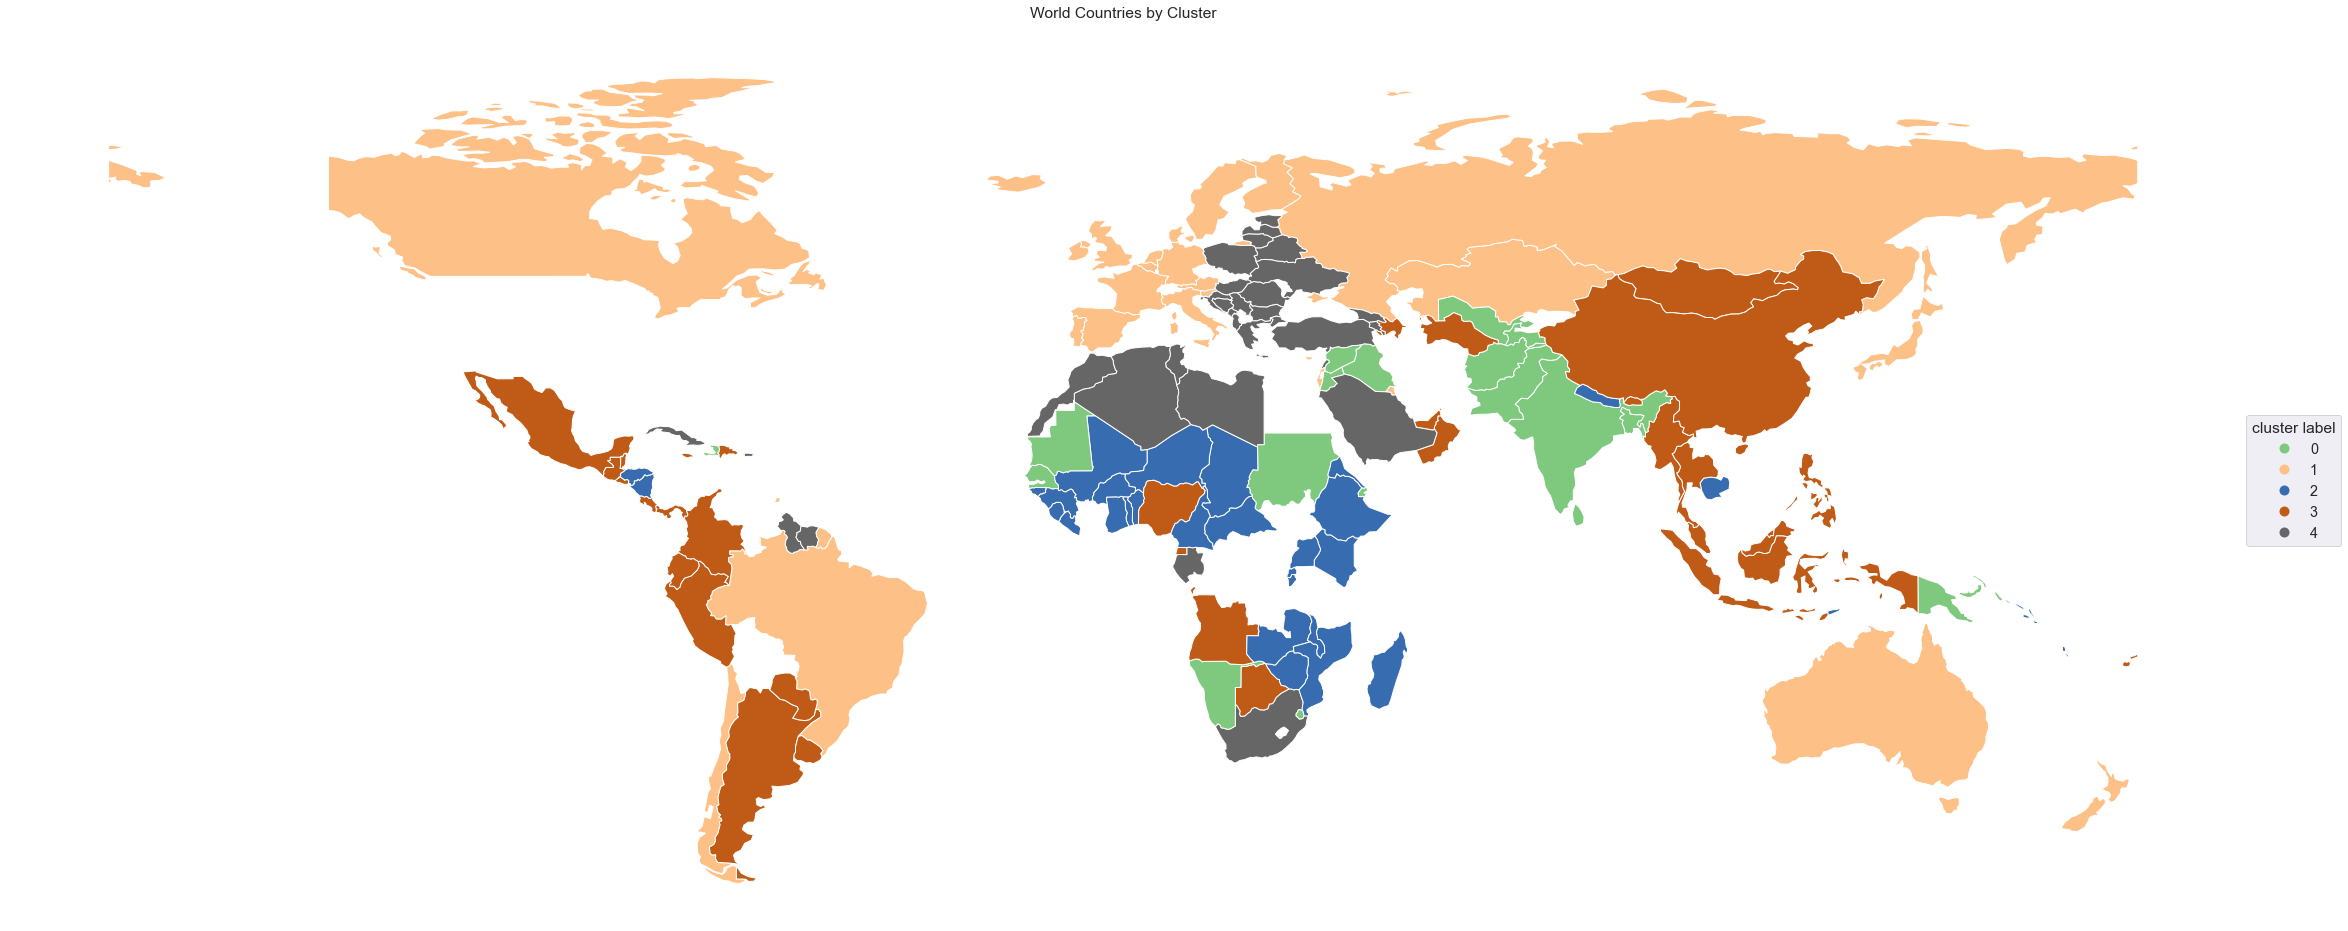

In [95]:
build_geo_df(world,df_cluster_11,df_pop,'2011')

<ipython-input-94-6ea5e66cf8a4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3'][df.name == 'France'] = df['iso_a3'][df.name == 'France'].replace({'-99':'FRA'})
<ipython-input-94-6ea5e66cf8a4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3'][df.name == 'Norway'] = df['iso_a3'][df.name == 'Norway'].replace({'-99':'NOR'})
<ipython-input-94-6ea5e66cf8a4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3

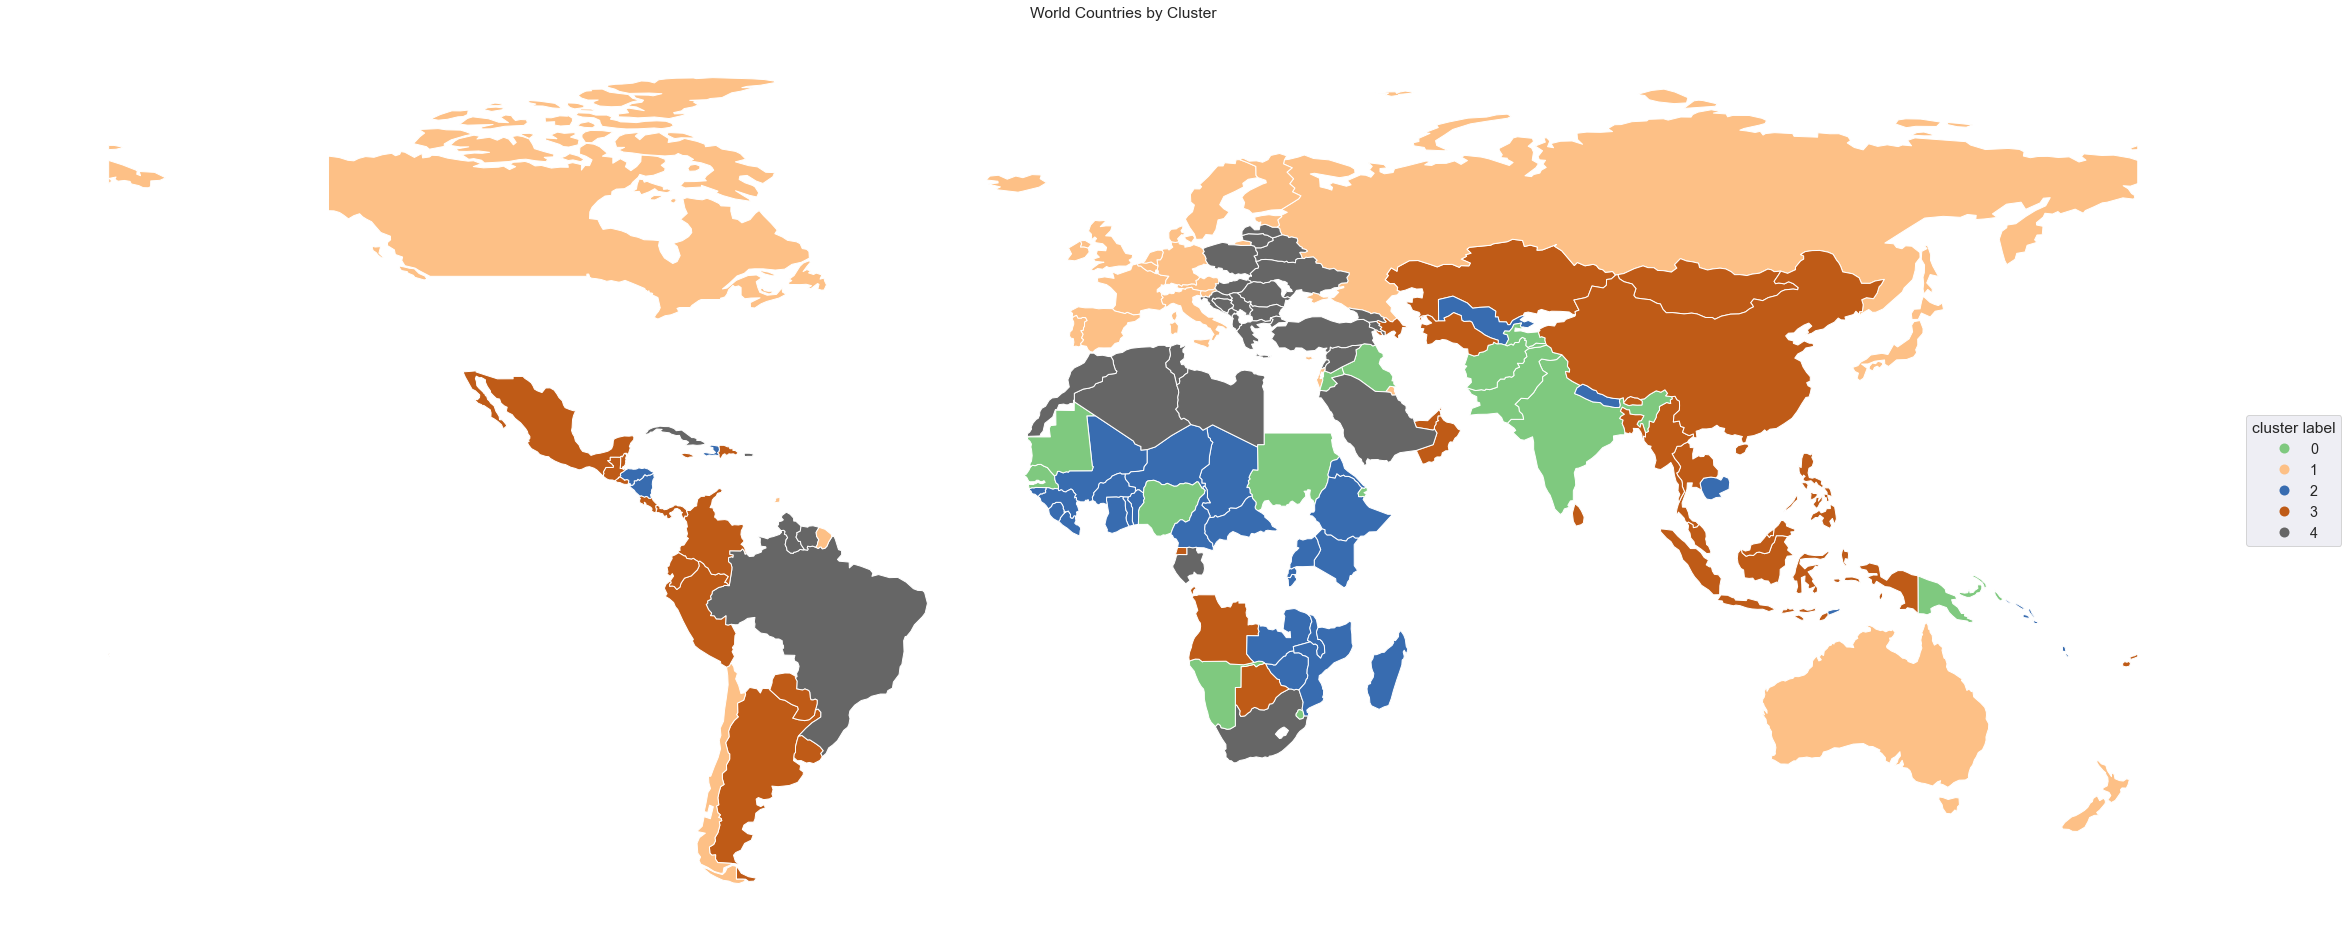

In [96]:
build_geo_df(world,df_cluster_2,df_pop,'2017')

In [97]:
#Paises que mudaram de clusters
df_cluster_2[df_cluster_2.labels != df_cluster_11.labels]

per_total_employment  all_disorders  week_hours_pc  \
location_name                                                              
Bangladesh                       56.290001   14013.357122      46.932260   
Brazil                           55.840000   16418.249906      37.705381   
Estonia                          60.090000   17488.412709      38.791686   
Haiti                            58.410000   12052.838198      40.336927   
Kazakhstan                       65.849998   13623.137560      38.090799   
Nigeria                          49.599998   11145.825045      43.060356   
Sri Lanka                        52.840000   13918.926569      41.891357   
Syrian Arab Republic             40.500000   14198.014814      42.196742   
Uzbekistan                       58.470001   11835.261443      39.721078   

                       gdp_per_cap  labels  
location_name                               
Bangladesh             1563.913699       3  
Brazil                 9925.386238       4  
Estonia               20458.460729       1  
Haiti                  1294.239746       2  
Kazakhstan             9247.581331       3  
Nigeria                1968.564738       0  
Sri Lanka              4077.043721       3  
Syrian Arab Republic   7021.323365       4  
Uzbekistan             1826.566919       2